# Table of Contents
- [0. Preamble](#Preamble)
- [1. Setup](#Setup)
- [2. Goalkeepers (GK)](#1:-Goalkeepers-(GK))
- [3. Defenders (DEF)](#2:-Defenders-(DEF))
- [4. Midfielders (MID)](#3:-Midfielders-(MID))
- [5. Forwards (FWD)](#4:-Forwards)
- [6. Combined Analysis & Forecasting](#Merging-Datasets)

In [54]:
# To load save weights ----
# Kaggle Export: The .hdf5 weight files saved in /kaggle/working/ will appear in the "Output" section of your Kaggle notebook session after it completes. You can download them from there.
# Loading Later: Remember, when you want to use these weights later (in another notebook or locally), you MUST:
# Rebuild the exact same model architecture using keras_model().
# Compile the model using the exact same optimizer, loss, and metrics.
# Load the weights using load_model_weights_hdf5().
# Load the corresponding scaling factors (mu, sigma, numF) to prepare input data and unscale predictions.

# Preamble

In [55]:
rm(list = ls(all = TRUE))

In [56]:
## 0: Preamble ----
Sys.setenv(WORKON_HOME = "C:/Users/peram/Documents/test/R Forecast/.virtualenvs")
reticulate::use_virtualenv("C:/Users/peram/Documents/test/R Forecast/.virtualenvs/r-reticulate", required = TRUE)
# Adjust code to chosen place of
# 1. Virtual Python Environment
# 2. Forces R session to use the a specific virtualenv
# This way the virtual environment does not get installed
# in your onedrive\documents folder.


#install.packages("keras")
library(reticulate)
#virtualenv_create("r-reticulate", python = install_python())
library(keras)
#install_keras(envname = "r-reticulate")

# Rest of the packages
if (!require("pacman")) install.packages("pacman")
pacman::p_load(ggthemes, tidyverse, slider,
                slider,glmnet,httr,jsonlite,tensorflow,
                randomForest, Metrics, pastecs,
                stats)

# Check if Keras and TF is properly installed
tf$constant("Hello, TensorFlow!")

# Lists to store models and scaling factors per position
model_list <- list()
scaling_factors <- list()

tf.Tensor(b'Hello, TensorFlow!', shape=(), dtype=string)

# Global user inputs

In [57]:
# Global user inputs ----
# Trainingsplit : in-sample <= split_gw < out-of-sample
split_gw <- 38+38

# LSTM
epoker <- 15
vindu <- 3

#Metrics for LSTM Models. Alle fungerer ikke fordi noen er for keras 3 eller heter noe annet som jeg ikke finner
metrics_regression <- c(
 # metric_mean_absolute_error(),
 # metric_mean_squared_error(),
  metric_root_mean_squared_error()
 # metric_mean_absolute_percentage_error(),
 # metric_cosine_similarity()
)

# Til Prognosering, hvor mange uker frem ønsker du å spå fremover
antall_uker <- 7

# Til patience epoker i callback.
# Altså hvor mange epoker skal den vente før den slutter å trene modellen og gå tilbake til siste beste
num_patience <- 5

# Decided embedding dimensions for pos.6 Building the Model
num_embedding_dimension <- 1

# Fetch data and prelim data manipulation

In [58]:
# Fetch data and prelim data manipulation ----
df <- read_csv("C:/Users/peram/Documents/test/Datasett/Ekstra kolonner, stigende GW, alle tre sesonger(22-24), heltall.csv")
alternativsammensatt <- df

Rows: 78025 Columns: 45
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): name, position, team, opponent_team
dbl  (39): xP, assists, bonus, bps, clean_sheets, creativity, expected_assis...
lgl   (1): was_home
dttm  (1): kickoff_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Position partitions

In [59]:
## Position partitions ----
gk <- alternativsammensatt |>
  filter(position == "GK")
def <- alternativsammensatt |>
  filter(position == "DEF")

mid <- alternativsammensatt |>
  filter(position == "MID")

fwd <- alternativsammensatt |>
  filter(position == "FWD")

posliste <- list(gk = gk, def = def, mid = mid, fwd = fwd)
lapply(posliste, head, n = 1);lapply(posliste, tail, n = 1)
str(gk)

unscaled_gk <- gk
unscaled_def <- def
unscaled_mid <- mid
unscaled_fwd <- fwd

name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Aaron Ramsdale,GK,Arsenal,3.6,0,0,25,1,0,0,⋯,0,50,FALSE,0,1,5,8,1,0,260
name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Aaron Anselmino,DEF,Chelsea,1.8,0,0,0,0,0,0,⋯,0,40,FALSE,0,101,1,5,7,0,1
name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Aaron Ramsey,MID,Burnley,1.2,0,0,3,0,1,0.01,⋯,51,50,TRUE,0,41,6,2,6,1,367
name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Zack Steffen,GK,Man City,0,0,0,0,0,0,0,⋯,154,39,TRUE,0,76,1330,23,16,1,77933
name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Zak Sturge,DEF,Chelsea,0,0,0,0,0,0,0,⋯,16,40,TRUE,0,76,1332,3,7,1,77949
name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Zidane Iqbal,MID,Man United,0,0,0,0,0,0,0,⋯,119,42,TRUE,0,38,1334,10,17,1,78025
name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,expected_assists,⋯,transfers_out,value,was_home,yellow_cards,GW,player_id,oID,tID,hID,row_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


spc_tbl_ [8,492 × 45] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ name                      : chr [1:8492] "Aaron Ramsdale" "Aaron Ramsdale" "Aaron Ramsdale" "Aaron Ramsdale" ...
 $ position                  : chr [1:8492] "GK" "GK" "GK" "GK" ...
 $ team                      : chr [1:8492] "Arsenal" "Arsenal" "Arsenal" "Arsenal" ...
 $ xP                        : num [1:8492] 3.6 4 5.3 4.8 3.9 2 3.5 3.3 2.5 5.3 ...
 $ assists                   : num [1:8492] 0 0 0 0 0 0 0 0 0 0 ...
 $ bonus                     : num [1:8492] 0 0 0 0 0 0 0 0 0 3 ...
 $ bps                       : num [1:8492] 25 10 20 12 13 14 24 12 15 32 ...
 $ clean_sheets              : num [1:8492] 1 0 1 0 0 0 1 0 0 1 ...
 $ creativity                : num [1:8492] 0 0 0 0 0 0 0 0 0 0 ...
 $ expected_assists          : num [1:8492] 0 0 0 0 0 0 0 0 0 0 ...
 $ expected_goal_involvements: num [1:8492] 0 0 0 0 0 0 0 0 0 0 ...
 $ expected_goals            : num [1:8492] 0 0 0 0 0 0 0 0 0 0 ...
 $ expected_goals_conceded  

# EDA 

Warning message in dir.create(plot_directory, recursive = TRUE):
"'C:\Users\peram\Documents\test\R Forecast\EDA' already exists"


Rows: 5,368
Columns: 2
$ total_points <dbl> 1, 1, 1, 2, 8, 0, 12, 1, 1, 6, 1, 6, 2, 5, 2, 5, 4, 0, 1,…
$ position     <fct> DEF, DEF, DEF, DEF, DEF, DEF, DEF, DEF, DEF, DEF, DEF, DE…
Position levels consistent between seasons: TRUE 


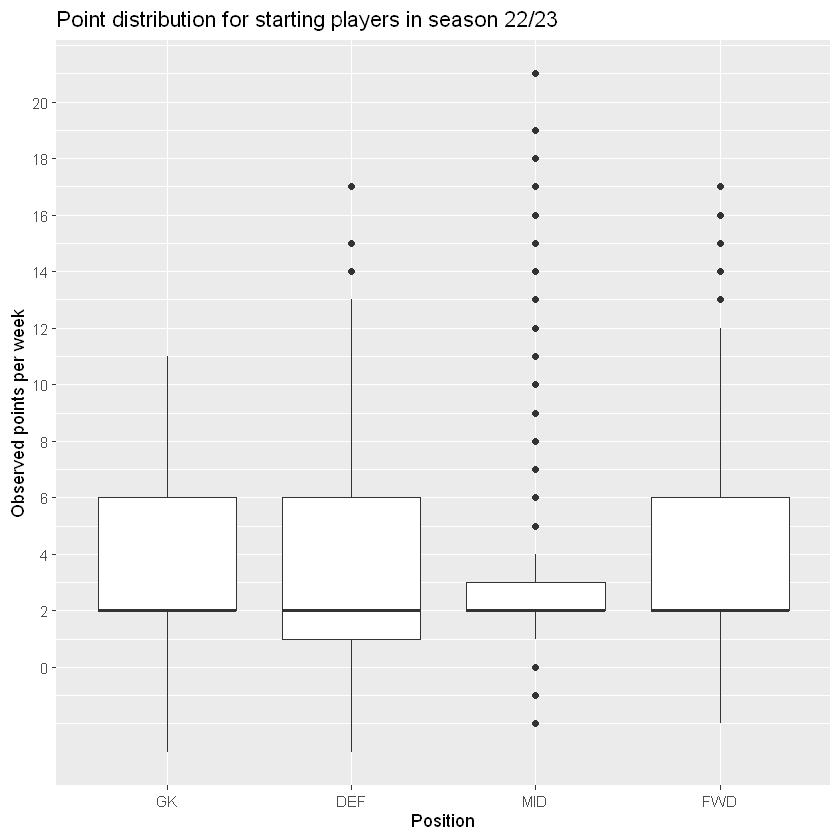

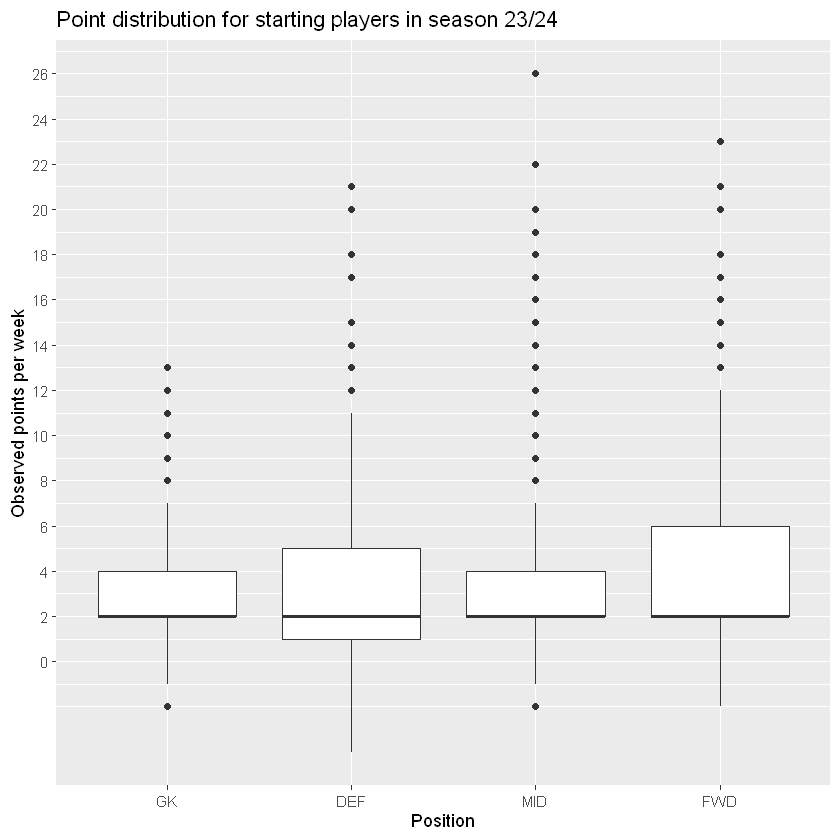

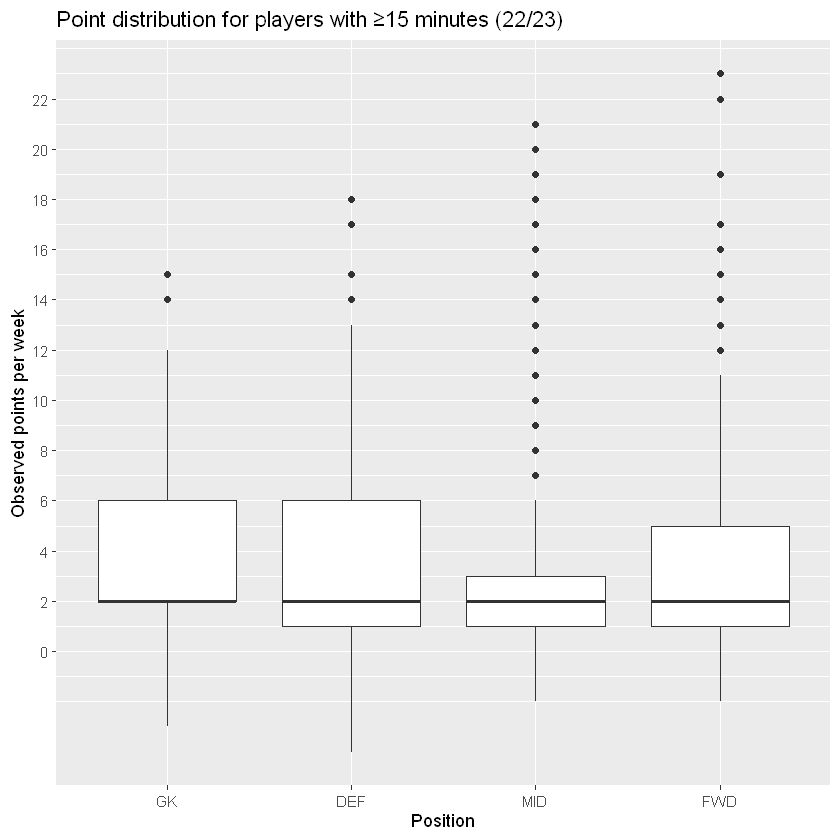

                   Metric Starters_22_23 Starters_23_24   Min15_22_23
nbr.val           nbr.val   5.368000e+03   8.360000e+03  9.982000e+03
nbr.null         nbr.null   2.650000e+02   4.830000e+02  5.490000e+02
nbr.na             nbr.na   0.000000e+00   0.000000e+00  0.000000e+00
min                   min  -3.000000e+00  -4.000000e+00 -4.000000e+00
max                   max   2.100000e+01   2.600000e+01  2.300000e+01
range               range   2.400000e+01   3.000000e+01  2.700000e+01
sum                   sum   1.781400e+04   2.720600e+04  3.017900e+04
median             median   2.000000e+00   2.000000e+00  2.000000e+00
mean                 mean   3.318554e+00   3.254306e+00  3.023342e+00
SE.mean           SE.mean   4.216345e-02   3.544907e-02  3.018881e-02
CI.mean.0.95 CI.mean.0.95   8.265749e-02   6.948897e-02  5.917617e-02
var                   var   9.542998e+00   1.050548e+01  9.097241e+00
std.dev           std.dev   3.089174e+00   3.241217e+00  3.016163e+00
coef.var         coe

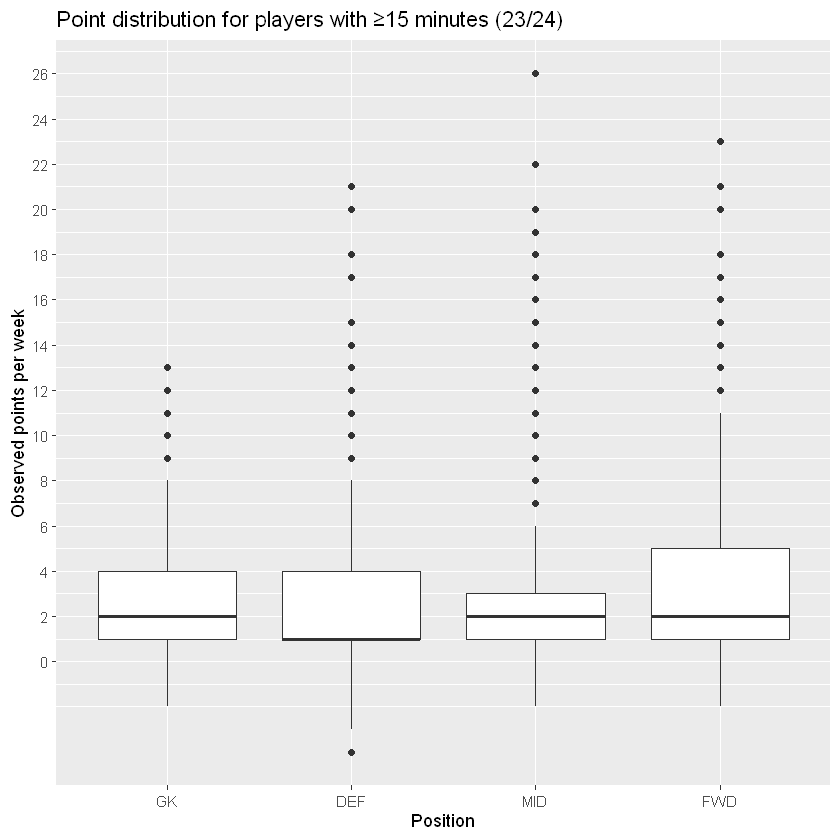

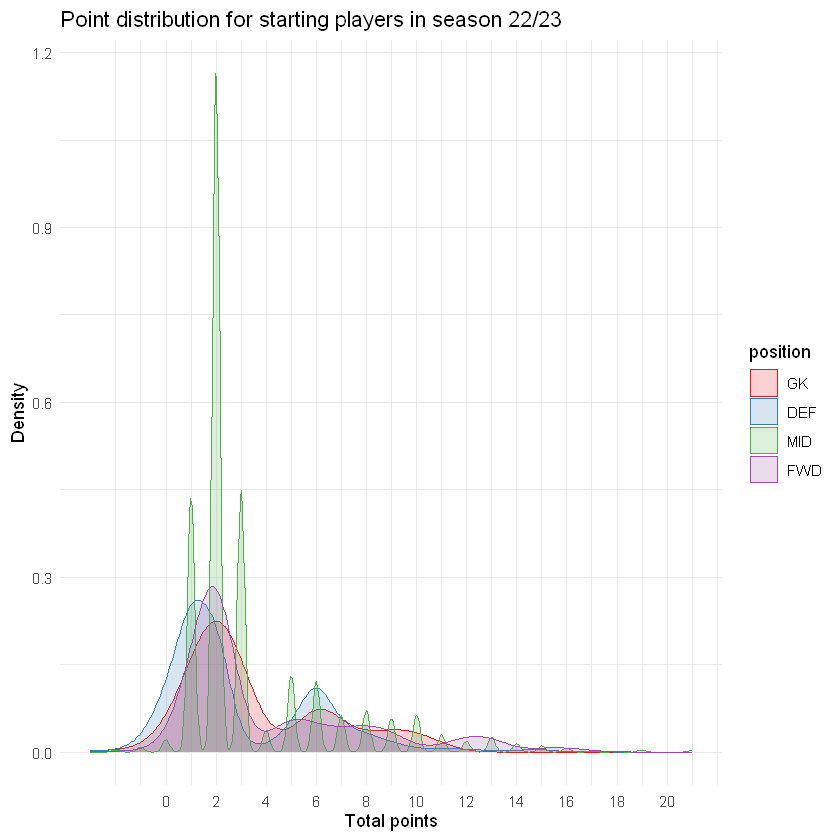

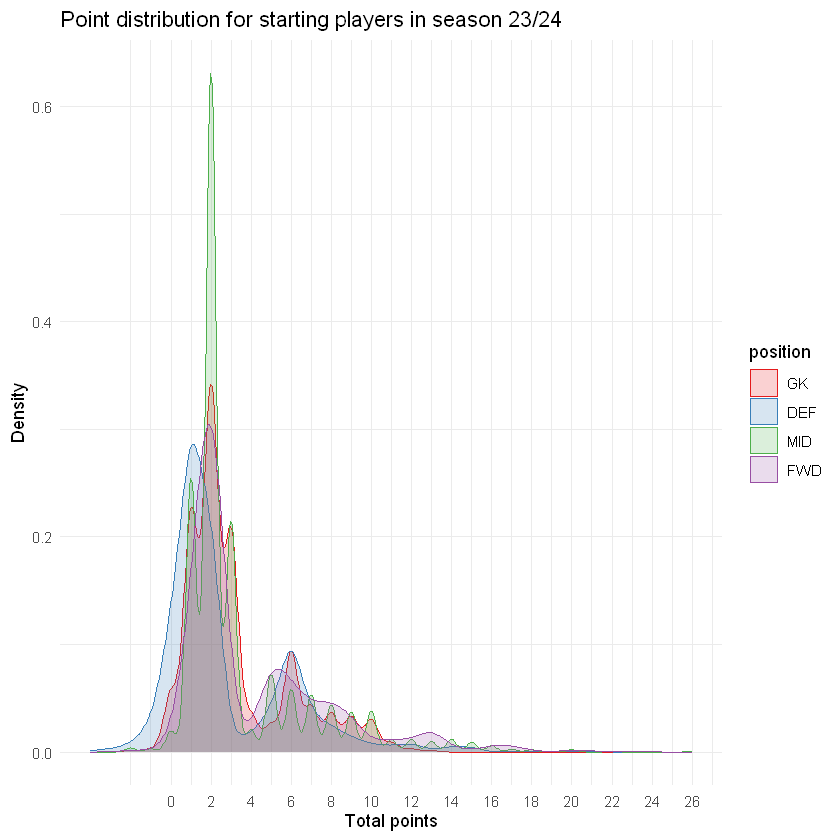

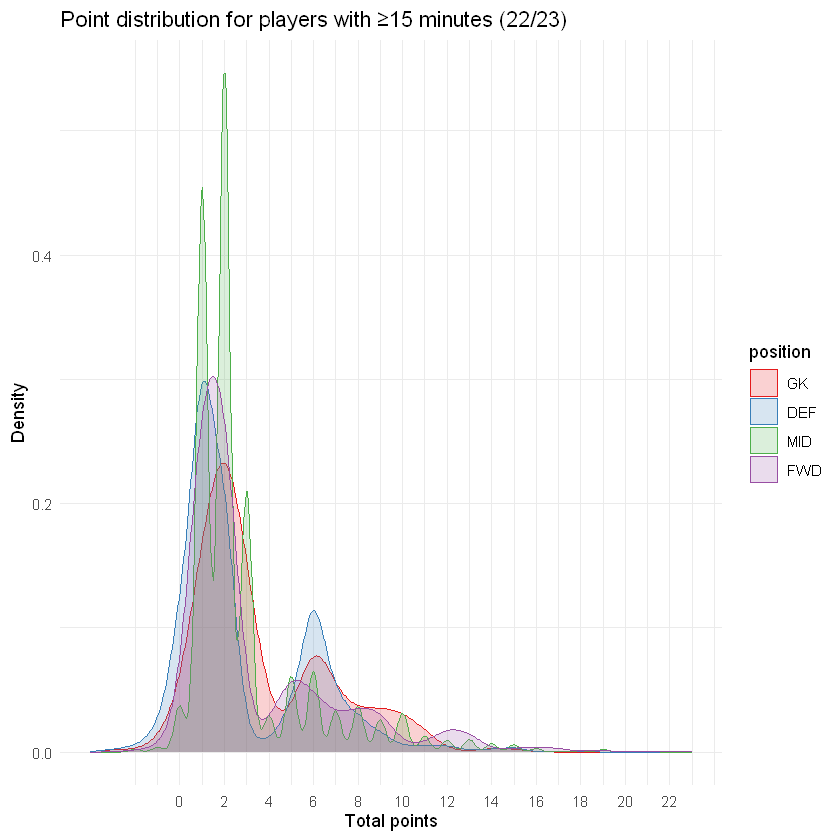

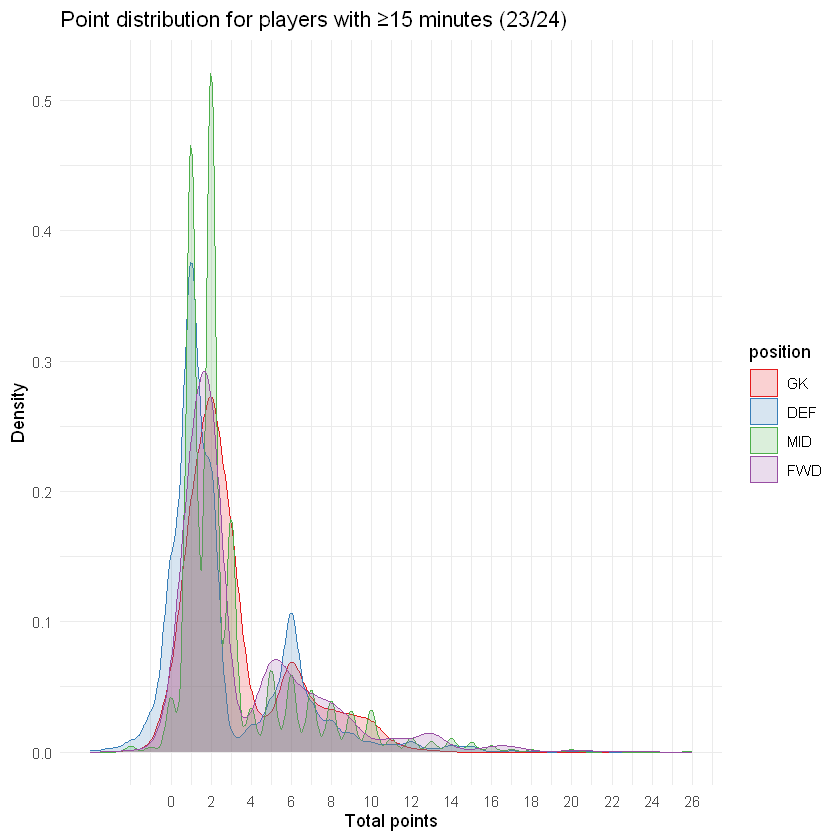

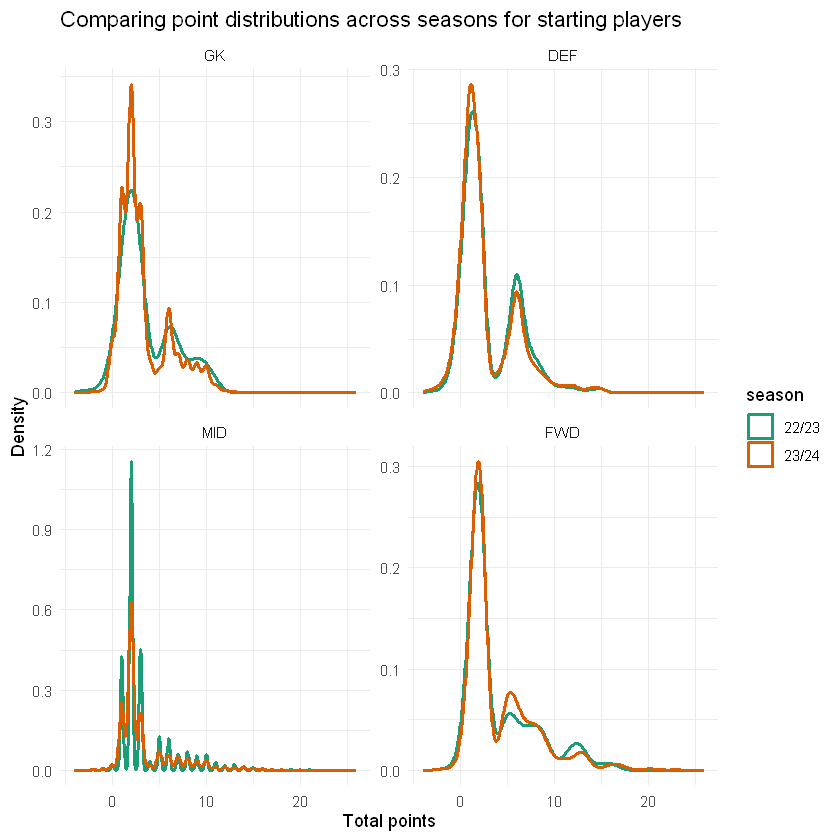

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

Position statistics for starters 22/23:
# A tibble: 4 × 7
  position Count  Mean Median    SD   Min   Max
  <fct>    <int> <dbl>  <dbl> <dbl> <dbl> <dbl>
1 GK         488  3.57      2  2.89    -3    11
2 DEF       1990  2.98      2  3.00    -3    17
3 MID       2342  3.38      2  3.01    -2    21
4 FWD        548  4.09      2  3.70    -2    17

Position statistics for starters 23/24:
# A tibble: 4 × 7
  position Count  Mean Median    SD   Min   Max
  <fct>    <int> <dbl>  <dbl> <dbl> <dbl> <dbl>
1 GK         760  3.23      2  2.64    -2    13
2 DEF       3150  2.73      2  3.14    -4    21
3 MID       3577  3.51      2  3.26    -2    26
4 FWD        873  4.12      2  3.68    -2    23


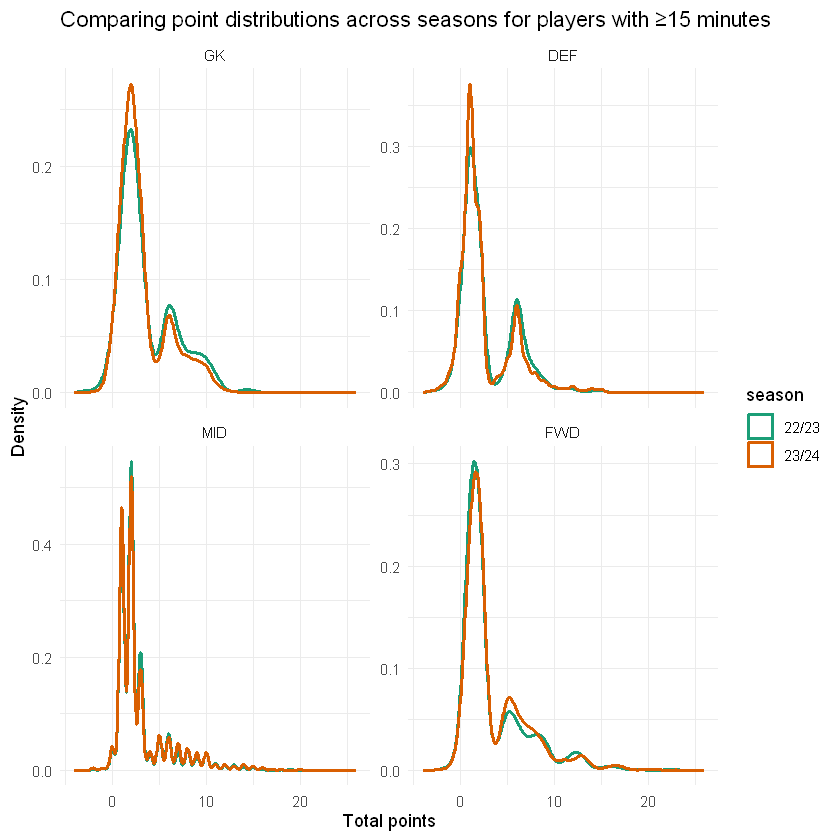

In [64]:
# EDA ----
# Where to save plots?
plot_directory <- "C:/Users/peram/Documents/test/R Forecast/EDA"
dir.create(plot_directory, recursive = TRUE)

# Define position order for consistent plotting
position_levels <- c("GK", "DEF", "MID", "FWD")

# Split data by season (assuming alternativsammensatt contains multiple seasons)
# Filter for season boundaries based on GW
season_22_23 <- alternativsammensatt |> filter(GW <= 38)
season_23_24 <- alternativsammensatt |> filter(GW > 38 , GW < 38+38+1)

# Create datasets of starting players
starters_22_23 <- season_22_23 |> 
  filter(starts == 1) |> 
  select(total_points, position) |>
  mutate(position = factor(position, levels = position_levels))

starters_23_24 <- season_23_24 |> 
  filter(starts == 1) |> 
  select(total_points, position) |>
  mutate(position = factor(position, levels = position_levels))

# Display dataset structure
glimpse(starters_22_23)
cat("Position levels consistent between seasons:", 
    identical(levels(starters_22_23$position), levels(starters_23_24$position)), "\n")

# Create boxplots for point distributions by position for starters
plot1 <- ggplot(starters_22_23, aes(x = position, y = total_points)) + 
  geom_boxplot() +
  labs(title = "Point distribution for starting players in season 22/23", 
       x = "Position", 
       y = "Observed points per week") +
  scale_y_continuous(breaks = seq(0, max(starters_22_23$total_points, na.rm = TRUE), 2)) 

plot2 <- ggplot(starters_23_24, aes(x = position, y = total_points)) +
  geom_boxplot() +
  labs(title = "Point distribution for starting players in season 23/24", 
       x = "Position", 
       y = "Observed points per week") +
  scale_y_continuous(breaks = seq(0, max(starters_23_24$total_points, na.rm = TRUE), 2)) 

# Display plots
plot1
plot2

# Create datasets of players with at least 15 minutes
players_15min_22_23 <- season_22_23 |> 
  filter(minutes >= 15) |> 
  select(total_points, position) |>
  mutate(position = factor(position, levels = position_levels))

players_15min_23_24 <- season_23_24 |> 
  filter(minutes >= 15) |> 
  select(total_points, position) |>
  mutate(position = factor(position, levels = position_levels))

# Create boxplots for players with at least 15 minutes
plot3 <- ggplot(players_15min_22_23, aes(x = position, y = total_points)) + 
  geom_boxplot() +
  labs(title = "Point distribution for players with ≥15 minutes (22/23)", 
       x = "Position", 
       y = "Observed points per week") +
  scale_y_continuous(breaks = seq(0, max(players_15min_22_23$total_points, na.rm = TRUE), 2))

plot4 <- ggplot(players_15min_23_24, aes(x = position, y = total_points)) +
  geom_boxplot() +
  labs(title = "Point distribution for players with ≥15 minutes (23/24)", 
       x = "Position", 
       y = "Observed points per week") +
  scale_y_continuous(breaks = seq(0, max(players_15min_23_24$total_points, na.rm = TRUE), 2))

# Display plots
plot3
plot4

# Save plots starting players
ggsave(file.path(plot_directory, "Point distribution for starting players in season 22-23.png"), 
       plot = plot1, width = 8, height = 6)
ggsave(file.path(plot_directory, "Point distribution for starting players in season 23-24.png"), 
       plot = plot2, width = 8, height = 6)

# Save plots 15 min play time or more
ggsave(file.path(plot_directory, "Point distribution for players with 15min+ playing time 22-23.png"), 
       plot = plot3, width = 8, height = 6)
ggsave(file.path(plot_directory, "Point distribution for players with 15min+ playing time 23-24.png"), 
       plot = plot4, width = 8, height = 6)# Hvordan er fordelingen av poeng for spillere som starter?

# Statistical summaries
# --------------------

# Create statistical summary tables
stats_starters_22_23 <- stat.desc(starters_22_23$total_points)
stats_starters_23_24 <- stat.desc(starters_23_24$total_points)
stats_15min_22_23 <- stat.desc(players_15min_22_23$total_points)
stats_15min_23_24 <- stat.desc(players_15min_23_24$total_points)

# Combine statistics for comparison
stats_comparison <- data.frame(
  Metric = rownames(as.data.frame(stats_starters_22_23)),
  Starters_22_23 = stats_starters_22_23,
  Starters_23_24 = stats_starters_23_24,
  Min15_22_23 = stats_15min_22_23,
  Min15_23_24 = stats_15min_23_24
)

print(stats_comparison)

# Distribution density plots for starting players ----
# Create distribution plots with different colors by position
dist_plot1 <- ggplot(starters_22_23, aes(x = total_points, fill = position, color = position)) + 
  geom_density(alpha = 0.2) +
  scale_color_brewer(palette = "Set1") +
  scale_fill_brewer(palette = "Set1") +
  labs(title = "Point distribution for starting players in season 22/23", 
       x = "Total points", 
       y = "Density") +
  theme_minimal() +
  scale_x_continuous(breaks = seq(0, max(starters_22_23$total_points, na.rm = TRUE), 2))

dist_plot2 <- ggplot(starters_23_24, aes(x = total_points, fill = position, color = position)) + 
  geom_density(alpha = 0.2) +
  scale_color_brewer(palette = "Set1") +
  scale_fill_brewer(palette = "Set1") +
  labs(title = "Point distribution for starting players in season 23/24", 
       x = "Total points", 
       y = "Density") +
  theme_minimal() +
  scale_x_continuous(breaks = seq(0, max(starters_23_24$total_points, na.rm = TRUE), 2))

# Display density plots for starters
dist_plot1
dist_plot2

# Save density plots for starters
ggsave(file.path(plot_directory, "Point density distribution for starting players 22-23.png"), 
       plot = dist_plot1, width = 10, height = 6)
ggsave(file.path(plot_directory, "Point density distribution for starting players 23-24.png"), 
       plot = dist_plot2, width = 10, height = 6)

# Distribution plots for players with at least 15 minutes
dist_plot3 <- ggplot(players_15min_22_23, aes(x = total_points, fill = position, color = position)) + 
  geom_density(alpha = 0.2) +
  scale_color_brewer(palette = "Set1") +
  scale_fill_brewer(palette = "Set1") +
  labs(title = "Point distribution for players with ≥15 minutes (22/23)", 
       x = "Total points", 
       y = "Density") +
  theme_minimal() +
  scale_x_continuous(breaks = seq(0, max(players_15min_22_23$total_points, na.rm = TRUE), 2))

dist_plot4 <- ggplot(players_15min_23_24, aes(x = total_points, fill = position, color = position)) + 
  geom_density(alpha = 0.2) +
  scale_color_brewer(palette = "Set1") +
  scale_fill_brewer(palette = "Set1") +
  labs(title = "Point distribution for players with ≥15 minutes (23/24)", 
       x = "Total points", 
       y = "Density") +
  theme_minimal() +
  scale_x_continuous(breaks = seq(0, max(players_15min_23_24$total_points, na.rm = TRUE), 2))

# Display density plots for 15+ minute players
dist_plot3
dist_plot4

# Save density plots for 15+ minute players
ggsave(file.path(plot_directory, "Point density distribution for players with 15min+ 22-23.png"), 
       plot = dist_plot3, width = 10, height = 6)
ggsave(file.path(plot_directory, "Point density distribution for players with 15min+ 23-24.png"), 
       plot = dist_plot4, width = 10, height = 6)

# Alternative overlaid distributions (combined in single plots)
# This shows the direct comparison between seasons for each position

# For starters: Compare 22/23 vs 23/24 by position
combined_starters <- bind_rows(
  mutate(starters_22_23, season = "22/23"),
  mutate(starters_23_24, season = "23/24")
)

pos_dist_starters <- ggplot(combined_starters, aes(x = total_points, color = season)) + 
  geom_density(linewidth = 1) +
  facet_wrap(~ position, scales = "free_y") +
  scale_color_manual(values = c("22/23" = "#1b9e77", "23/24" = "#d95f02")) +
  labs(title = "Comparing point distributions across seasons for starting players",
       x = "Total points",
       y = "Density") +
  theme_minimal()

pos_dist_starters

# For 15+ minute players: Compare 22/23 vs 23/24 by position
combined_15min <- bind_rows(
  mutate(players_15min_22_23, season = "22/23"),
  mutate(players_15min_23_24, season = "23/24")
)

pos_dist_15min <- ggplot(combined_15min, aes(x = total_points, color = season)) + 
  geom_density(linewidth = 1) +
  facet_wrap(~ position, scales = "free_y") +
  scale_color_manual(values = c("22/23" = "#1b9e77", "23/24" = "#d95f02")) +
  labs(title = "Comparing point distributions across seasons for players with ≥15 minutes",
       x = "Total points",
       y = "Density") +
  theme_minimal()

pos_dist_15min

# Save the combined comparison plots
ggsave(file.path(plot_directory, "Season comparison starters by position.png"), 
       plot = pos_dist_starters, width = 10, height = 8)
ggsave(file.path(plot_directory, "Season comparison 15min+ by position.png"), 
       plot = pos_dist_15min, width = 10, height = 8)
       
# QQ Plots to check normality
# --------------------------

# QQ Plot for starters 22/23
png(file.path(plot_directory, "QQ Plot of Starters 22-23 Points.png"), width = 800, height = 600)
qqnorm(starters_22_23$total_points, col = "blue", pch = 20,
       main = "Q-Q Plot of Starters 22/23 Points",
       xlab = "Theoretical Quantiles",
       ylab = "Sample Quantiles")
qqline(starters_22_23$total_points, col = "red", lwd = 2)
dev.off()

# QQ Plot for starters 23/24
png(file.path(plot_directory, "QQ Plot of Starters 23-24 Points.png"), width = 800, height = 600)
qqnorm(starters_23_24$total_points, col = "blue", pch = 20,
       main = "Q-Q Plot of Starters 23/24 Points",
       xlab = "Theoretical Quantiles",
       ylab = "Sample Quantiles")
qqline(starters_23_24$total_points, col = "red", lwd = 2)
dev.off()

# QQ Plot for 15+ minutes players 22/23
png(file.path(plot_directory, "QQ Plot of Players 15min+ 22-23 Points.png"), width = 800, height = 600)
qqnorm(players_15min_22_23$total_points, col = "blue", pch = 20,
       main = "Q-Q Plot of Players with ≥15 Minutes 22/23 Points",
       xlab = "Theoretical Quantiles",
       ylab = "Sample Quantiles")
qqline(players_15min_22_23$total_points, col = "red", lwd = 2)
dev.off()

# QQ Plot for 15+ minutes players 23/24
png(file.path(plot_directory, "QQ Plot of Players 15min+ 23-24 Points.png"), width = 800, height = 600)
qqnorm(players_15min_23_24$total_points, col = "blue", pch = 20,
       main = "Q-Q Plot of Players with ≥15 Minutes 23/24 Points",
       xlab = "Theoretical Quantiles",
       ylab = "Sample Quantiles")
qqline(players_15min_23_24$total_points, col = "red", lwd = 2)
dev.off()

# Additional analysis - Points by position
# ---------------------------------------
# Create summary statistics by position for each dataset
position_stats_starters_22_23 <- starters_22_23 |>
  group_by(position) |>
  summarize(
    Count = n(),
    Mean = mean(total_points, na.rm = TRUE),
    Median = median(total_points, na.rm = TRUE),
    SD = sd(total_points, na.rm = TRUE),
    Min = min(total_points, na.rm = TRUE),
    Max = max(total_points, na.rm = TRUE)
  )

position_stats_starters_23_24 <- starters_23_24 |>
  group_by(position) |>
  summarize(
    Count = n(),
    Mean = mean(total_points, na.rm = TRUE),
    Median = median(total_points, na.rm = TRUE),
    SD = sd(total_points, na.rm = TRUE),
    Min = min(total_points, na.rm = TRUE),
    Max = max(total_points, na.rm = TRUE)
  )

# Print position-based statistics
cat("Position statistics for starters 22/23:\n")
print(position_stats_starters_22_23)
cat("\nPosition statistics for starters 23/24:\n")
print(position_stats_starters_23_24)

# 1: Goalkeepers (GK)

In [8]:
# 1: Goalkeepers (GK)

## GK 1.1 Define Features, Target & Scale

In [9]:
## GK 1.1 Define Features, Target & Scale ----

numF <- c("assists", "creativity", "minutes", "goals_conceded", "saves",
          "bonus", "bps", "expected_assists", "expected_goal_involvements",
          "expected_goals", "ict_index", "own_goals", "red_cards",
          "threat", "transfers_in", "transfers_out", "yellow_cards",
          "expected_goals_conceded", "penalties_saved", "value",
          "selected", "transfers_balance", "starts", "influence",
          "clean_sheets")
catF <- c("player_id", "tID", "oID", "hID")
tar <- "total_points"

cat("Numeriske features:", numF, "\n")
cat("Kategoriske features:", catF, "\n")
cat("Target variabel:", tar, "\n")
cat("Ferdig\n")

# Compute and store the mean and standard deviation for the target variable

mu <- mean(gk[[tar]], na.rm = TRUE)
sigma <- sd(gk[[tar]], na.rm = TRUE)

# Scale numerical features and target
gk <- gk %>%
  mutate(across(all_of(numF), ~ (.x - mean(.x, na.rm = TRUE)) / sd(.x, na.rm = TRUE)),
         !!tar := (.data[[tar]] - mu) / sigma)
cat("Chunk done")

Numeriske features: assists creativity minutes goals_conceded saves bonus bps expected_assists expected_goal_involvements expected_goals ict_index own_goals red_cards threat transfers_in transfers_out yellow_cards expected_goals_conceded penalties_saved value selected transfers_balance starts influence clean_sheets 
Kategoriske features: player_id tID oID hID 
Target variabel: total_points 
Ferdig
Chunk done

## GK 1.2: Build Rolling Windows

In [10]:
# GK 1.2: Build Rolling Windows ----

# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- gk %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(gk %>% select(row_id, GW), by = "row_id")

# Build categorical rolling windows (if needed for debugging; here we use only the current values)
catW <- gk %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%
  group_modify(~ {
    df <- ungroup(.x) %>% mutate(player_id = .y$player_id)
    windows <- slide(df %>% select(all_of(catF)),
                     .f = ~ as.matrix(.x),
                     .before = ws,
                     #.after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- df[[tar]][(ws + 1):nrow(df)]
    tibble(window = valid_windows, target = target)
  }) %>%
  ungroup()

cat("Chunk done\n")

Chunk done


## GK 1.3: Lasso regression

In [11]:
## GK 1.3: Lasso regression ----

# Check for any NA in the windows before summary
sumna <- sapply(numW$window, function(flatW) any(is.na(flatW)))
cat("Windows with NA: ", sum(sumna), "\n")

# numW as data.matrix, tar as response variable
aggmat <- lapply(numW$window, function(flatW){
  colMeans(flatW, na.rm = TRUE)
})
x <- do.call(rbind, aggmat)
y <- numW$target

# K-fold CV
cvfit <- cv.glmnet(x,y,alpha=1)
minlambda <- cvfit$lambda.min

lassofit <- glmnet(x,y,alpha = 1, lambda = minlambda)

coef_lasso <- as.matrix(coef(lassofit))
numF <- rownames(coef_lasso)[coef_lasso[,1] != 0]
numF <- setdiff(numF, "(Intercept)")
cat("Selected features: ", numF, "\n")

# repeat rolling window, now only containing selected features
# Define window size (number of past gameweeks to use)
ws <- vindu


# Build numerical rolling windows
numW <- gk %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(gk %>% select(row_id, GW), by = "row_id")

Windows with NA:  0 
Selected features:  assists minutes bps expected_assists own_goals threat transfers_out expected_goals_conceded penalties_saved value selected transfers_balance clean_sheets 


## GK 1.4: Convert Rolling Windows

In [12]:
## GK 1.4: Convert Rolling Windows ----

# Number of samples is the number of rows in numW
nSamp <- nrow(numW)

# Convert numerical windows to a 3D array of shape [nSamp, ws, length(numF)]
num_array <- array(
  unlist(numW$window),
  dim = c(nSamp, ws, length(numF))
)

# Targets (scaled): a matrix with one column
targets <- matrix(as.numeric(numW$target), ncol = 1)

# For categorical inputs, extract the current categorical values from the last row of each window.
# (If your windows were built solely from historical data, the "current" values need to come from the original data.)
# Here, we use the categorical rolling windows and extract the last row:
cat_current <- do.call(rbind, lapply(catW$window, function(mat) mat[nrow(mat), ]))
# Split into separate matrices (each of shape [nSamp, 1])
cat_player_id <- matrix(as.integer(cat_current[, "player_id"]), ncol = 1)
cat_tID <- matrix(as.integer(cat_current[, "tID"]), ncol = 1)
cat_oID <- matrix(as.integer(cat_current[, "oID"]), ncol = 1)
cat_hID <- matrix(as.integer(cat_current[, "hID"]), ncol = 1)

cat("Chunk done\n")

Chunk done


## GK 1.5: Split Data into Training and Validation Sets

In [13]:
## GK 1.5: Split Data into Training and Validation Sets ----
idx <- which(numW$GW <= split_gw)

# Training data
Xnum_train <- num_array[idx, , , drop = FALSE]
cat_player_id_train <- cat_player_id[idx, , drop = FALSE]
cat_tID_train <- cat_tID[idx, , drop = FALSE]
cat_oID_train <- cat_oID[idx, , drop = FALSE]
cat_hID_train <- cat_hID[idx, , drop = FALSE]
y_train <- targets[idx, , drop = FALSE]

# Validation data
Xnum_val <- num_array[-idx, , , drop = FALSE]
cat_player_id_val <- cat_player_id[-idx, , drop = FALSE]
cat_tID_val <- cat_tID[-idx, , drop = FALSE]
cat_oID_val <- cat_oID[-idx, , drop = FALSE]
cat_hID_val <- cat_hID[-idx, , drop = FALSE]
y_val <- targets[-idx, , drop = FALSE]

# Also, extract the row IDs for the validation samples (for later joining)
val_row_ids <- numW$row_id[-idx]

cat("Chunk GK 1.4 done")

Chunk GK 1.4 done

## GK 1.6: Building the Keras Neural Network Model 

Model: "Goalkeeper_LSTM_Model"
________________________________________________________________________________
 Layer (type)           Output Shape            Param   Connected to            
                                                 #                              
 input_player_id (Inpu  [(None, 1)]             0       []                      
 tLayer)                                                                        
 input_tID (InputLayer  [(None, 1)]             0       []                      
 )                                                                              
 input_oID (InputLayer  [(None, 1)]             0       []                      
 )                                                                              
 input_hID (InputLayer  [(None, 1)]             0       []                      
 )                                                                              
 embedding_18 (Embeddi  (None, 1, 1)            1331    ['input_player_id[0][0

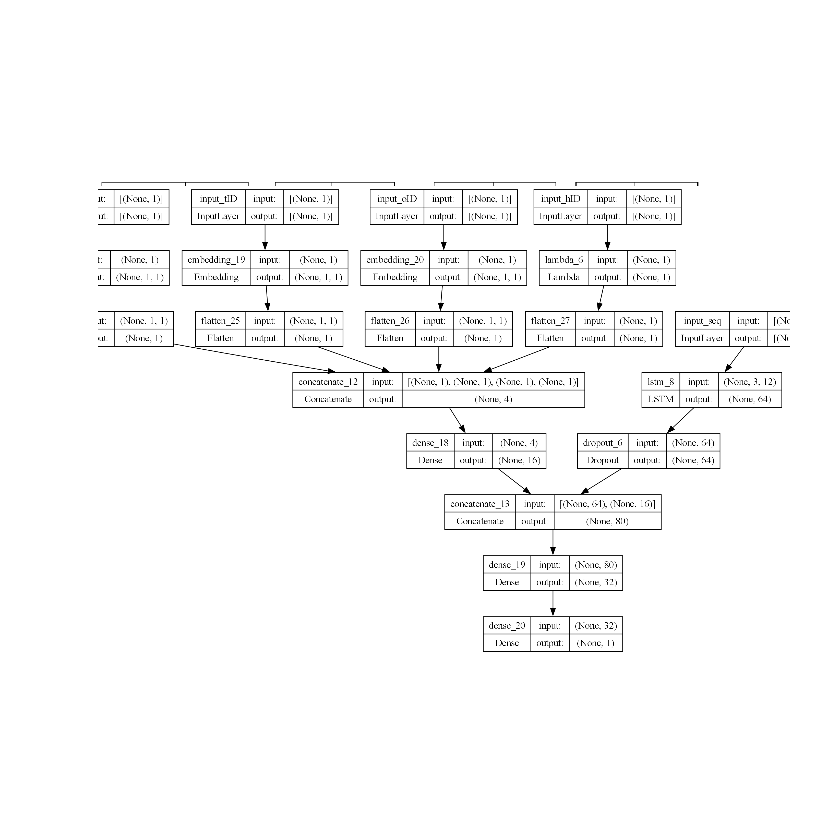

In [ ]:
## GK 1.6: Building the Keras Neural Network Model ----

# Define maximum values for categorical features
num_players   <- max(gk$player_id)
num_teams     <- max(gk$tID)
num_opponents <- max(gk$oID)
 
embedding_dimension <- num_embedding_dimension  # Embedding dimension

# Create input layers for current categorical values
input_player_id <- layer_input(shape = c(1), dtype = "int32", name = "input_player_id")
input_tID <- layer_input(shape = c(1), dtype = "int32", name = "input_tID")
input_oID <- layer_input(shape = c(1), dtype = "int32", name = "input_oID")
input_hID <- layer_input(shape = c(1), dtype = "int32", name = "input_hID")

embedding_player_id <- input_player_id %>% 
  layer_embedding(input_dim = num_players + 1, output_dim = embedding_dimension, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_tID <- input_tID %>% 
  layer_embedding(input_dim = num_teams + 1, output_dim = embedding_dimension, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_oID <- input_oID %>% 
  layer_embedding(input_dim = num_opponents + 1, output_dim = embedding_dimension, mask_zero = TRUE) %>% 
  layer_flatten()
# For hID, convert to float32 to match types
input_hID_flat <- input_hID %>% 
  layer_lambda(function(x) tf$cast(x, tf$float32)) %>% 
  layer_flatten()

# Merge categorical branch
cat_merged <- layer_concatenate(list(embedding_player_id, embedding_tID, embedding_oID, input_hID_flat)) %>%
  layer_dense(units = 16, activation = "relu")

# Numerical branch: input for rolling window data
input_seq <- layer_input(shape = c(ws, length(numF)), name = "input_seq")
lstm_branch <- input_seq %>%
  layer_lstm(units = 64, return_sequences = FALSE) %>%
  layer_dropout(rate = 0.2)

# Merge both branches and build the output
merged <- layer_concatenate(list(lstm_branch, cat_merged))
dense_layer <- merged %>% layer_dense(units = 32, activation = "relu")
output <- dense_layer %>% layer_dense(units = 1, activation = "linear")

# Build and compile the model
model <- keras_model(
  inputs = list(input_seq, input_player_id, input_tID, input_oID, input_hID),
  outputs = output,
    name = "Goalkeeper_LSTM_Model"
)
model %>% compile(
  optimizer = optimizer_adam(),
  loss = "mse",
  metrics = metrics_regression,
  run_eagerly = FALSE
)

summary(model)
plot(model)

# Access the Python keras module directly
keras_python <- import("keras")

# Generate the plot with your desired parameters
keras_python$utils$plot_model(
  model,
  to_file = "keras-model-gk.png",
  show_shapes = TRUE,  # Set to TRUE to see tensor shapes
  show_dtype = FALSE,
  show_layer_names = TRUE,
  rankdir = "TB",      # "TB" (top to bottom) or "LR" (left to right)
  expand_nested = FALSE,
  dpi = 200,
  show_layer_activations = FALSE
)

# Display the image in R
library(png) # or library(png) depending on your output format
img <- readPNG("keras-model-gk.png") # or readJPEG for jpeg format
grid::grid.raster(img)

## GK 1.7 Short explaination

1. Legger til funksjonen callback_early_stopping().
- Patience := Hvor mange epoker skal den fortsette fra siste "bunn" verdien til loss funksjonen før den stopper tidlig og laster inn sist laveste observert prediksjons error.

2. Legger til Checkpoints slik at vektene til modellen kan lagres

3. callback_reduce_lr_on_plateau(): Denne funksjonen brukes for å automatisere leæringssteg. Factor bestemmer hvor mye vi skal korte ned på hvert læringssteg(i prosent) når vi ikke forbedrer val_loss etter patience p.
![Grafisk fremstilling av hvordan funksjonen fungerer](https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png)

## GK 1.7: Callback Functions and Scaling Factors

In [15]:
## GK 1.7: Callback Functions and Scaling Factors ----

# Filepath for saving the BEST weights (unique for each position)
weights_filepath_gk <- "R Forecast/best_gk.hdf5"
cat("Will save best GK weights to:", weights_filepath_gk, "\n")

# 1. Tidlig stopp funksjon, laster inn siste beste loss value.
# patience: how many epochs to wait after last improvement before stopping
# restore_best_weights: load the weights from the epoch with the best val_loss
early_stopping <- callback_early_stopping(
    monitor = "val_loss",
    patience = num_patience, 
    restore_best_weights = TRUE
)

# 2. Model Checkpoint Callback (to save best weights)
model_checkpoint <- callback_model_checkpoint(
    filepath = weights_filepath_gk, # Path defined above
    monitor = "val_loss",           # Monitor the same metric as early stopping
    save_best_only = TRUE,          # IMPORTANT: Only save when val_loss improves
    save_weights_only = TRUE,       # IMPORTANT: Save ONLY the weights, not the whole model
    mode = "min",                   # We want to minimize loss
    verbose = 1                     # Optional: print message when weights are saved
)

# 3. Reduce Learning Rate on Plateau Callback
reduce_lr <- callback_reduce_lr_on_plateau(
    monitor = "val_loss",  # Monitor validation loss (same as early stopping)
    factor = 0.2,          # Reduce LR to 20% of its current value (lr * factor)
    patience = num_patience,           # Reduce LR if val_loss doesn't improve for 5 epochs
    min_lr = 1e-6,         # Don't reduce the LR below this value
    verbose = 1            # Print a message when LR is reduced
)

scaling_factors$gk <- list(mu = mu,
                           sigma = sigma,
                           numF = numF) # numF here is the one selected by Lasso for GK
cat("GK scaling factors stored.\n")

Will save best GK weights to: R Forecast/best_gk.hdf5 
GK scaling factors stored.


## GK 1.8: Train Goalkeeper LSTM Model

In [16]:
## MID 1.8: Train Goalkeeper LSTM Model ----

cat("Starting GK model training...\n")
history <- model %>% fit(
  x = list(
    input_seq = Xnum_train,
    input_player_id = cat_player_id_train,
    input_tID = cat_tID_train,
    input_oID = cat_oID_train,
    input_hID = cat_hID_train
  ),
  y = y_train,
  epochs = epoker,          
  batch_size = 16,          # Try increasing batch size (e.g., 64 or 128) for speed
  validation_data = list(
    list(
      input_seq = Xnum_val,
      input_player_id = cat_player_id_val,
      input_tID = cat_tID_val,
      input_oID = cat_oID_val,
      input_hID = cat_hID_val
    ),
    y_val
  ),
  # ADD THE CALLBACKS HERE
  callbacks = list(early_stopping, model_checkpoint, reduce_lr)
)
cat("GK model training finished.\n")

Starting GK model training...
GK model training finished.


## GK 1.9: Generate Predictions & Invert Scaling on Validation Set

In [17]:
## GK 1.9: Generate Predictions & Invert Scaling on Validation Set ----
# Use the validation set for predictions
pred_all <- model %>% predict(
  list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  )
)

# Build a predictions table using the validation row IDs
preds_gk <- tibble(
  row_id = val_row_ids,  # row IDs corresponding to the validation set
  predicted_total_points_scaled = as.vector(pred_all),
  actual_total_points_scaled = as.vector(y_val)
) %>% 
  mutate(
    predicted_total_points = predicted_total_points_scaled * sigma + mu,
    actual_total_points = actual_total_points_scaled * sigma + mu
  )


preds_gk <- preds_gk %>%
  left_join(unscaled_gk, by = "row_id") # Use unscaled_gk

# View the predictions table
glimpse(preds_gk)

Rows: 2,228
Columns: 49
$ row_id                        <dbl> 336, 337, 338, 339, 340, 341, 342, 343, …
$ predicted_total_points_scaled <dbl> 0.30709454, 0.16133744, 0.14813511, 0.25…
$ actual_total_points_scaled    <dbl> -0.42194588, -0.42194588, 0.55840006, 1.…
$ predicted_total_points        <dbl> 1.4873126, 1.1899541, 1.1630200, 1.38649…
$ actual_total_points           <dbl> 0, 0, 2, 3, 3, 2, 2, 1, 4, 9, 0, 0, 0, 0…
$ name                          <chr> "Aaron Ramsdale", "Aaron Ramsdale", "Aar…
$ position                      <chr> "GK", "GK", "GK", "GK", "GK", "GK", "GK"…
$ team                          <chr> "Arsenal", "Arsenal", "Southampton", "So…
$ xP                            <dbl> 3.2, 1.0, 0.2, 0.7, 2.0, 2.2, 1.0, 1.2, …
$ assists                       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ bonus                         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0…
$ bps                           <dbl> 0, 0, 5, 12, 15, 5, 5, -2, 24, 33, 5, 0,…
$ clean_sheets  

## GK 1.10: Save model and validation set predictions

In [18]:
## GK 1.10 Save model and validation set predictions ----
# Store GK model and scaling factors 
model_list$gk <- model
cat("GK model stored in Notebook Memory/R Session.\n")

# PyCapsule Error makes this unusable l.6-l.8
# filepath <- "C:/Users/peram/Documents/test/R Forecast/Saved-tf-models"
# save_model_tf(object = model, filepath = filepath)

# Clean up validation predictions (select essential columns)
preds_gk_clean <- preds_gk %>%
  select(row_id, GW, player_id, name, position, team,
   actual_total_points, predicted_total_points, value)
cat("Validation Predictions stored in preds_gk_clean.\n")

GK model stored in Notebook Memory/R Session.
Validation Predictions stored in preds_gk_clean.


## GK 1.11: Plots for Evaluation

In [19]:
## GK 1.11: Plots for Evaluation ----

### GK 1.11.1 Save training and fit history

In [20]:
## GK 1.11 Lagre History til Evaluation ----
history_gk <- history #class() "keras_training_history"
history_df_gk <- data.frame(history_gk)

### GK 1.11.2 Training History Plot

   epoch     value                  metric       data
1      1 0.9779280                    loss   training
2      2 0.7102698                    loss   training
3      3 0.6514462                    loss   training
4      4 0.6366878                    loss   training
5      5 0.6299173                    loss   training
6      6 0.6181366                    loss   training
7      7 0.6113736                    loss   training
8      8 0.6042217                    loss   training
9      9 0.6035050                    loss   training
10    10 0.5927239                    loss   training
11    11 0.5904400                    loss   training
12    12 0.5793297                    loss   training
13    13        NA                    loss   training
14    14        NA                    loss   training
15    15        NA                    loss   training
16     1 0.9889024 root_mean_squared_error   training
17     2 0.8427750 root_mean_squared_error   training
18     3 0.8071222 root_mean

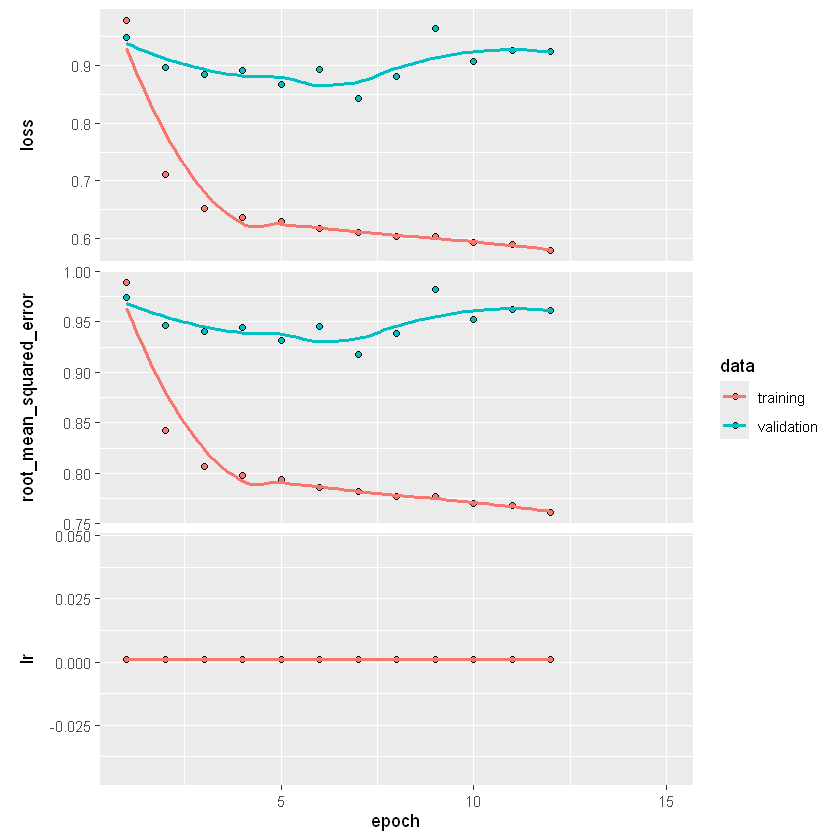

In [21]:
### GK 1.11.2 Training History Plot ----
plot_history_gk <- plot(history_gk)
plot_history_gk
print(history_df_gk)

### GK 1.11.3 Actual Y vs Predicted hat Y points

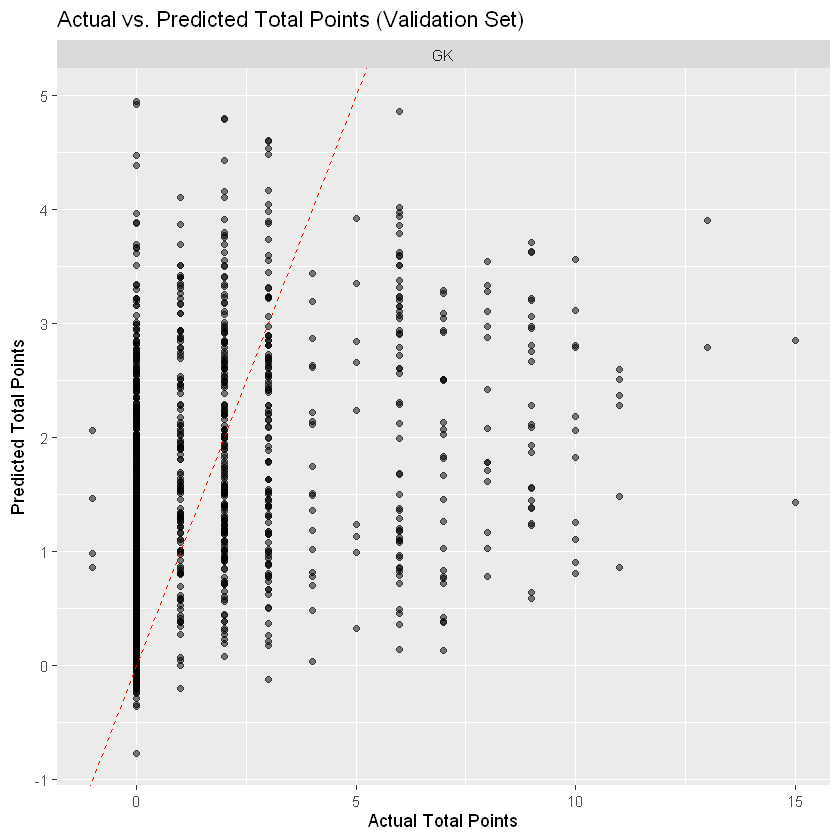

In [22]:
### GK 1.11.3 Actual Y vs Predicted hat Y points ----
plot_actual_predicted_gk <- ggplot(preds_gk, aes(x = actual_total_points, y = predicted_total_points)) +
  geom_point(alpha = 0.5) + # Use alpha for transparency if many points overlap
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") + # y=x line
  labs(title = "Actual vs. Predicted Total Points (Validation Set)",
       x = "Actual Total Points",
       y = "Predicted Total Points") +
  facet_wrap(~ position) + # Optional: Separate plots by position
  theme_grey() +
  coord_cartesian(xlim = range(preds_gk$actual_total_points, na.rm = TRUE), # Adjust limits if needed
                  ylim = range(preds_gk$predicted_total_points, na.rm = TRUE))
plot_actual_predicted_gk                  

### GK 1.11.4: Residuals vs Predicted

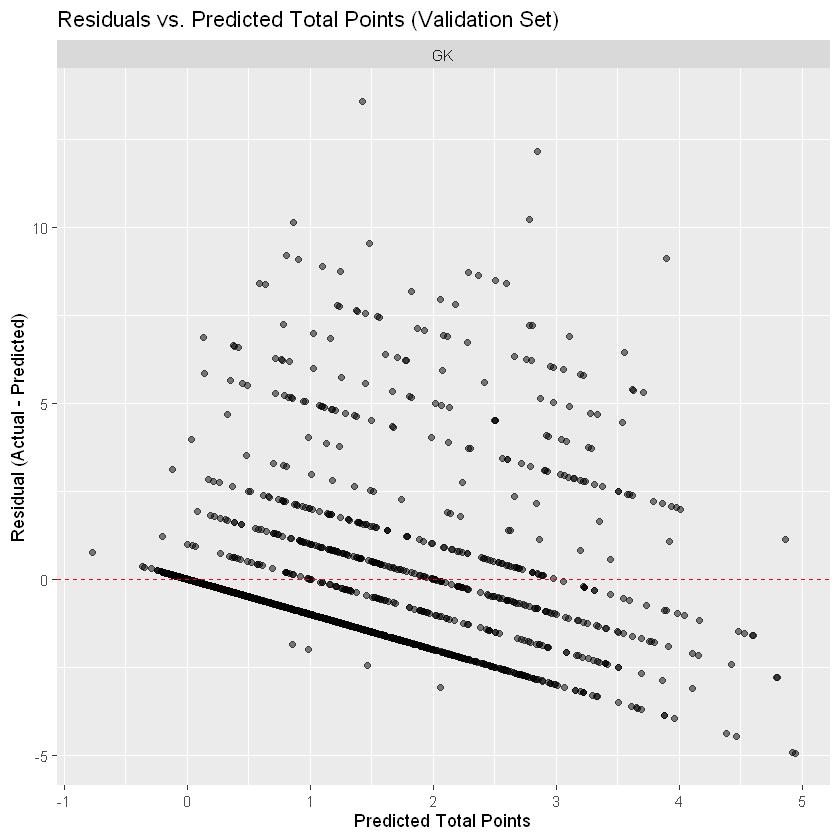

In [23]:
### GK 1.11.4: Residuals vs Predicted ----

preds_gk_residuals <- preds_gk # Make copy to add residuals column
preds_gk_residuals <- preds_gk_residuals %>%
  mutate(residual = actual_total_points - predicted_total_points)

plot_residuals_predicted_gk <- ggplot(preds_gk_residuals, aes(x = predicted_total_points, y = residual)) +
  geom_point(alpha = 0.5) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") + # Zero error line
  labs(title = "Residuals vs. Predicted Total Points (Validation Set)",
       x = "Predicted Total Points",
       y = "Residual (Actual - Predicted)") +
  facet_wrap(~ position) + # Optional
  theme_grey()  
plot_residuals_predicted_gk

### GK 1.11.5: Distribution of Residuals

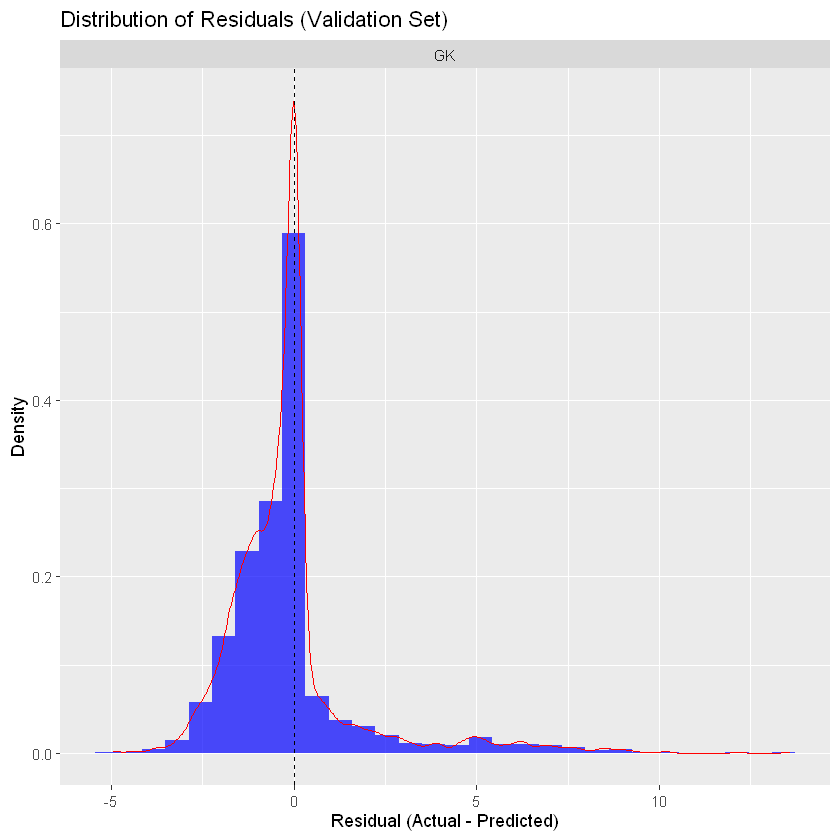

In [24]:
### GK 1.11.5: Distribution of Residuals ----
plot_distribution_residuals_gk <- ggplot(preds_gk_residuals, aes(x = residual)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "blue", alpha = 0.7) +
  geom_density(color = "red") +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +
  labs(title = "Distribution of Residuals (Validation Set)",
       x = "Residual (Actual - Predicted)",
       y = "Density") +
  facet_wrap(~ position) + # Optional
  theme_grey()
plot_distribution_residuals_gk

### GK 1.11.6 Return list containing loss value and metrics

In [25]:
### GK 1.11.6 Return list containing loss value and metrics ----
# After training, evaluate the model on validation data with all metrics
model_evaluation <- model %>% keras::evaluate(
  x = list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  ),
  y = y_val,
  verbose = 1
)

# Print the evaluation results (metrics specified during compilation)
print(model_evaluation)

# Combine results by position
validation_metrics <- list()
validation_metrics$gk <- model_list$gk %>% evaluate(
  x = list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  ),
  y = y_val
)

                   loss root_mean_squared_error 
              0.8425056               0.9178810 


# 2: Defenders (DEF)

In [26]:
# 2: Defenders (DEF) ----

## DEF 2.1: Define Features, Target & Scale

In [27]:
## DEF 2.1: Define Features, Target & Scale ----

numF <- c("assists", "creativity", "minutes", "goals_conceded",
          "bonus", "bps", "expected_assists", "expected_goal_involvements",
          "expected_goals", "ict_index", "own_goals", "red_cards",
          "threat", "transfers_in", "transfers_out", "yellow_cards",
          "expected_goals_conceded", "value",
          "selected", "transfers_balance", "starts", "influence",
          "clean_sheets")
catF <- c("player_id", "tID", "oID", "hID")
tar <- "total_points"

cat("Numeriske features:", numF, "\n")
cat("Kategoriske features:", catF, "\n")
cat("Target variabel:", tar, "\n")
cat("Ferdig")
# Compute and store the mean and standard deviation for the target variable

mu <- mean(def[[tar]], na.rm = TRUE)
sigma <- sd(def[[tar]], na.rm = TRUE)

# Scale numerical features and target
def <- def %>%
  mutate(across(all_of(numF), ~ (.x - mean(.x, na.rm = TRUE)) / sd(.x, na.rm = TRUE)),
         !!tar := (.data[[tar]] - mu) / sigma)

cat("Kjørt")

Numeriske features: assists creativity minutes goals_conceded bonus bps expected_assists expected_goal_involvements expected_goals ict_index own_goals red_cards threat transfers_in transfers_out yellow_cards expected_goals_conceded value selected transfers_balance starts influence clean_sheets 
Kategoriske features: player_id tID oID hID 
Target variabel: total_points 
FerdigKjørt

## DEF 2.2: Building rolling windows

In [28]:
## DEF 2.2 Build Rolling Windows ----

# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- def %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1, # prevents the model from seeing current gw data
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(def %>% select(row_id, GW), by = "row_id")
# Build categorical rolling windows (if needed for debugging; here we use only the current values)
catW <- def %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%
  group_modify(~ {
    df <- ungroup(.x) %>% mutate(player_id = .y$player_id)
    windows <- slide(df %>% select(all_of(catF)),
                     .f = ~ as.matrix(.x),
                     .before = ws,
                     #.after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- df[[tar]][(ws + 1):nrow(df)]
    tibble(window = valid_windows, target = target)
  }) %>%
  ungroup()

cat("Kjørt")

Kjørt

## DEF 2.3: Lasso Regression

In [29]:
## DEF 2.3. Lasso regression ----
# Check for any NA in the windows before summary
sumna <- sapply(numW$window, function(flatW) any(is.na(flatW)))
cat("Windows with NA: ", sum(sumna), "\n")
# numW as data.matrix, tar as response variable

aggmat <- lapply(numW$window, function(flatW){
  colMeans(flatW, na.rm = TRUE)
})
x <- do.call(rbind, aggmat)
y <- numW$target

# K-fold CV
cvfit <- cv.glmnet(x,y,alpha=1)
minlambda <- cvfit$lambda.min

lassofit <- glmnet(x,y,alpha = 1, lambda = minlambda)

coef_lasso <- as.matrix(coef(lassofit))
numF <- rownames(coef_lasso)[coef_lasso[,1] != 0]
numF <- setdiff(numF, "(Intercept)")
cat("Selected features: ", numF, "\n")

# repeat rolling window, now only containing selected features
# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- def %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(def %>% select(row_id, GW), by = "row_id")

cat("Kjørt")

Windows with NA:  0 
Selected features:  creativity minutes bonus bps expected_goal_involvements red_cards threat transfers_in expected_goals_conceded value selected transfers_balance 
Kjørt

## DEF 2.4: Convert Rolling Windows to Arrays & Extract Targets

In [30]:
## DEF 2.4 Convert Rolling Windows to Arrays & Extract Targets ----

# Number of samples is the number of rows in numW
nSamp <- nrow(numW)

# Convert numerical windows to a 3D array of shape [nSamp, ws, length(numF)]
num_array <- array(
  unlist(numW$window),
  dim = c(nSamp, ws, length(numF))
)

# Targets (scaled): a matrix with one column
targets <- matrix(as.numeric(numW$target), ncol = 1)

# For categorical inputs, extract the current categorical values from the last row of each window.
# (If your windows were built solely from historical data, the "current" values need to come from the original data.)
# Here, we use the categorical rolling windows and extract the last row:
cat_current <- do.call(rbind, lapply(catW$window, function(mat) mat[nrow(mat), ]))
# Split into separate matrices (each of shape [nSamp, 1])
cat_player_id <- matrix(as.integer(cat_current[, "player_id"]), ncol = 1)
cat_tID <- matrix(as.integer(cat_current[, "tID"]), ncol = 1)
cat_oID <- matrix(as.integer(cat_current[, "oID"]), ncol = 1)
cat_hID <- matrix(as.integer(cat_current[, "hID"]), ncol = 1)

## DEF 2.5: Data split 

In [31]:
# DEF 2.5 Split Data into Training and Validation Sets ----

idx <- which(numW$GW <= split_gw)

# Training data
Xnum_train <- num_array[idx, , , drop = FALSE]
cat_player_id_train <- cat_player_id[idx, , drop = FALSE]
cat_tID_train <- cat_tID[idx, , drop = FALSE]
cat_oID_train <- cat_oID[idx, , drop = FALSE]
cat_hID_train <- cat_hID[idx, , drop = FALSE]
y_train <- targets[idx, , drop = FALSE]

# Validation data
Xnum_val <- num_array[-idx, , , drop = FALSE]
cat_player_id_val <- cat_player_id[-idx, , drop = FALSE]
cat_tID_val <- cat_tID[-idx, , drop = FALSE]
cat_oID_val <- cat_oID[-idx, , drop = FALSE]
cat_hID_val <- cat_hID[-idx, , drop = FALSE]
y_val <- targets[-idx, , drop = FALSE]

# Also, extract the row IDs for the validation samples (for later joining)
val_row_ids <- numW$row_id[-idx]

## DEF 2.6: Building the Keras Neural Network Model 

Model: "def_lstm_model"
________________________________________________________________________________
 Layer (type)           Output Shape            Param   Connected to            
                                                 #                              
 input_player_id (Inpu  [(None, 1)]             0       []                      
 tLayer)                                                                        
 input_tID (InputLayer  [(None, 1)]             0       []                      
 )                                                                              
 input_oID (InputLayer  [(None, 1)]             0       []                      
 )                                                                              
 input_hID (InputLayer  [(None, 1)]             0       []                      
 )                                                                              
 embedding_9 (Embeddin  (None, 1, 1)            1335    ['input_player_id[0][0]'
 g) 

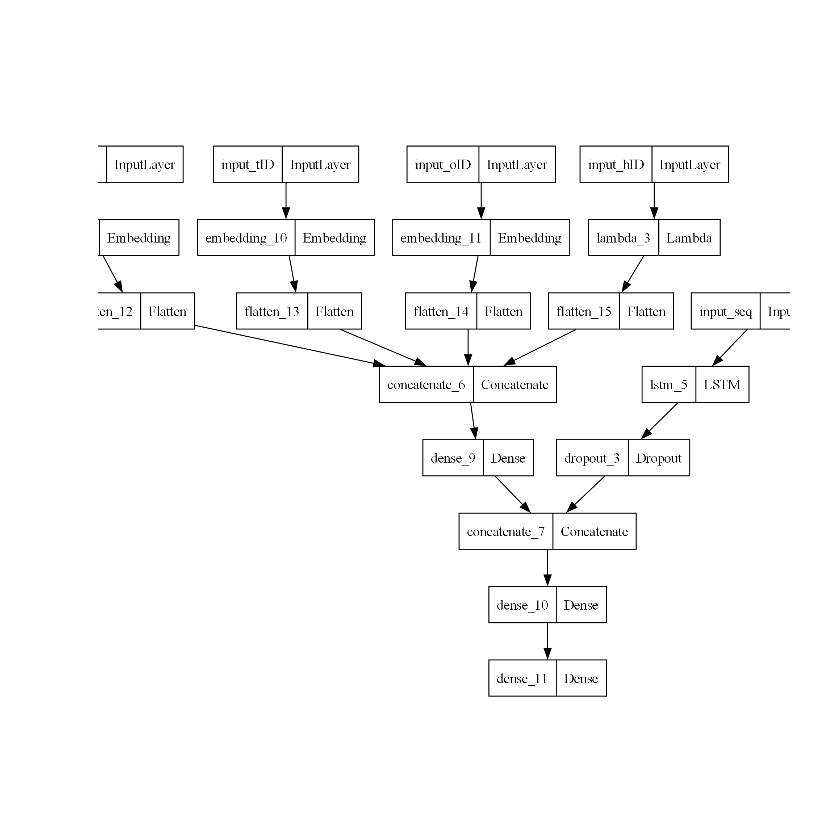

In [44]:
## DEF 2.6 Keras Neural Network Model

# Define maximum values for categorical features
num_players   <- max(mid$player_id)
num_teams     <- max(mid$tID)
num_opponents <- max(mid$oID)

embedding_dimension <- num_embedding_dimension  # Embedding dimension

# Create input layers for current categorical values
input_player_id <- layer_input(shape = c(1), dtype = "int32", name = "input_player_id")
input_tID <- layer_input(shape = c(1), dtype = "int32", name = "input_tID")
input_oID <- layer_input(shape = c(1), dtype = "int32", name = "input_oID")
input_hID <- layer_input(shape = c(1), dtype = "int32", name = "input_hID")

embedding_player_id <- input_player_id %>% 
  layer_embedding(input_dim = num_players + 1, output_dim = embedding_dimension, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_tID <- input_tID %>% 
  layer_embedding(input_dim = num_teams + 1, output_dim = embedding_dimension, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_oID <- input_oID %>% 
  layer_embedding(input_dim = num_opponents + 1, output_dim = embedding_dimension, mask_zero = TRUE) %>% 
  layer_flatten()
# For hID, convert to float32 to match types
input_hID_flat <- input_hID %>% 
  layer_lambda(function(x) tf$cast(x, tf$float32)) %>% 
  layer_flatten()

# Merge categorical branch
cat_merged <- layer_concatenate(list(embedding_player_id, embedding_tID, embedding_oID, input_hID_flat)) %>%
  layer_dense(units = 16, activation = "relu")
#### NEW 
# Add this after your input layers but before LSTM processing
#input_seq_with_noise <- input_seq %>%
#  layer_gaussian_noise(stddev = 0.1) %>%  # Adjust stddev as needed
#  layer_lstm(units = 64, return_sequences = FALSE)
##### END NEW

# Numerical branch: input for rolling window data
input_seq <- layer_input(shape = c(ws, length(numF)), name = "input_seq")
lstm_branch <- input_seq %>%
  layer_lstm(units = 64, return_sequences = FALSE) %>%
  layer_dropout(rate = 0.2)

# Merge both branches and build the output
merged <- layer_concatenate(list(lstm_branch, cat_merged))
dense_layer <- merged %>% layer_dense(units = 32, activation = "relu")
output <- dense_layer %>% layer_dense(units = 1, activation = "linear")

# Build and compile the model
model <- keras_model(
  inputs = list(input_seq, input_player_id, input_tID, input_oID, input_hID),
  outputs = output,
    name = "def_lstm_model"
)
model %>% compile(
  optimizer = optimizer_adam(),
  loss = "mse",
  metrics = metrics_regression,
  run_eagerly = TRUE
)

summary(model)
plot(model)

# Access the Python keras module directly
keras_python <- import("keras")

# Generate the plot with your desired parameters
keras_python$utils$plot_model(
  model,
  to_file = "keras-model-def.png",
  show_shapes = FALSE,  # Set to TRUE to see tensor shapes
  show_dtype = FALSE,
  show_layer_names = TRUE,
  rankdir = "TB",      # "TB" (top to bottom) or "LR" (left to right)
  expand_nested = FALSE,
  dpi = 200,
  show_layer_activations = FALSE
)

# Display the image in R
library(png) # or library(png) depending on your output format
img <- readPNG("keras-model-def.png") # or readJPEG for jpeg format
grid::grid.raster(img)

## DEF 2.7: Callback Functions and Scaling Factors

In [46]:
## DEF 2.7: Callback Functions and Scaling Factors ----
# Filepath for saving the BEST weights (unique for each position)
weights_filepath_def <- "R Forecast/best_def.hdf5"
cat("Will save best DEF weights to:", weights_filepath_def, "\n")

# 1. Early Stopping Callback
early_stopping <- callback_early_stopping(
    monitor = "val_loss",       # Monitor validation loss
    patience = num_patience,              # Stop after 10 epochs of no improvement
    restore_best_weights = TRUE # Optional but good: restores weights from the best epoch at the end of training
                                # Note: Checkpoint callback is the primary saver here.
)

# 2. Model Checkpoint Callback (to save best weights)
model_checkpoint <- callback_model_checkpoint(
    filepath = weights_filepath_def, # Path defined above
    monitor = "val_loss",           # Monitor the same metric as early stopping
    save_best_only = TRUE,          # IMPORTANT: Only save when val_loss improves
    save_weights_only = TRUE,       # IMPORTANT: Save ONLY the weights, not the whole model
    mode = "min",                   # We want to minimize loss
    verbose = 1                     # Optional: print message when weights are saved
)

reduce_lr <- callback_reduce_lr_on_plateau(
    monitor = "val_loss",  # Monitor validation loss (same as early stopping)
    factor = 0.2,          # Reduce LR to 20% of its current value (lr * factor)
    patience = 5,           # Reduce LR if val_loss doesn't improve for 5 epochs
    min_lr = 1e-6,         # Don't reduce the LR below this value
    verbose = 1            # Print a message when LR is reduced
)

# Store scaling factors NOW (before potential errors during training)
# Ensure mu, sigma, and numF (Lasso selected) are correctly captured from the GK scaling steps
scaling_factors$def <- list(
    mu = mu,         # Mean of GK target used for scaling
    sigma = sigma,   # SD of GK target used for scaling
    numF = numF      # Vector of Lasso-selected numerical feature names for GK
)
cat("DEF scaling factors stored.\n")

Will save best DEF weights to: R Forecast/best_def.hdf5 


DEF scaling factors stored.


## DEF 2.8: Train Defender LSTM Model 

In [35]:
## DEF 2.8: Train Defender LSTM Model  ----
cat("Starting DEF model training...\n")
history <- model %>% fit(
  x = list(
    input_seq = Xnum_train,
    input_player_id = cat_player_id_train,
    input_tID = cat_tID_train,
    input_oID = cat_oID_train,
    input_hID = cat_hID_train
  ),
  y = y_train,
  epochs = epoker,          # Max epochs
  batch_size = 64,          # Try increasing batch size (e.g., 64 or 128) for speed
  validation_data = list(
    list(
      input_seq = Xnum_val,
      input_player_id = cat_player_id_val,
      input_tID = cat_tID_val,
      input_oID = cat_oID_val,
      input_hID = cat_hID_val
    ),
    y_val
  ),
  # ADD THE CALLBACKS HERE
  callbacks = list(early_stopping, model_checkpoint, reduce_lr)
)
cat("DEF model training finished.\n")

Starting DEF model training...
DEF model training finished.


## DEF 2.9: Generate Predictions & Invert Scaling on Validation Set

In [36]:
## DEF 2.9: Generate Predictions & Invert Scaling on Validation Set ----

# Use the validation set for predictions
pred_all <- model %>% predict(
  list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  )
)

# Build a predictions table using the validation row IDs
preds_def <- tibble(
  row_id = val_row_ids,  # row IDs corresponding to the validation set
  predicted_total_points_scaled = as.vector(pred_all),
  actual_total_points_scaled = as.vector(y_val)
) %>% 
  mutate(
    predicted_total_points = predicted_total_points_scaled * sigma + mu,
    actual_total_points = actual_total_points_scaled * sigma + mu
  )

preds_def <- preds_def %>%
  left_join(unscaled_def, by = "row_id") # Use unscaled_def

# View the predictions table
glimpse(preds_def)

Rows: 7,026
Columns: 49
$ row_id                        <dbl> 4, 5, 6, 7, 122, 123, 124, 125, 126, 127…
$ predicted_total_points_scaled <dbl> -0.020753419, -0.107889391, -0.052617792…
$ actual_total_points_scaled    <dbl> -0.46568846, -0.46568846, -0.46568846, -…
$ predicted_total_points        <dbl> 0.9777294, 0.7862511, 0.9077086, 1.03859…
$ actual_total_points           <dbl> 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0…
$ name                          <chr> "Aaron Anselmino", "Aaron Anselmino", "A…
$ position                      <chr> "DEF", "DEF", "DEF", "DEF", "DEF", "DEF"…
$ team                          <chr> "Chelsea", "Chelsea", "Chelsea", "Chelse…
$ xP                            <dbl> 0.5, 0.0, 0.5, 0.5, 1.0, 0.5, -0.2, 0.1,…
$ assists                       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ bonus                         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ bps                           <dbl> 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 2, 0, 1, 0…
$ clean_sheets  

## DEF 2.10: Save model and validation set predictions

In [37]:
## DEF 2.10 Save model and validation set predictions ----
# Store DEF model and scaling factors
model_list$def <- model
cat("DEF model and scaling factors stored.\n")

# Clean up validation predictions (select essential columns)
preds_def_clean <- preds_def %>%
  select(row_id, GW, player_id, name, position, team, # Identifiers from unscaled_def join
         actual_total_points, predicted_total_points, value)
cat("Validation Predictions stored in preds_def_clean.\n")

DEF model and scaling factors stored.
Validation Predictions stored in preds_def_clean.


## DEF 2.11: Plots for Evalutaion

### DEF 2.11.1 Save training and fit history

In [38]:
### DEF 2.11.1 Save training and fit history ----
history_def <- history #class() "keras_training_history"
history_df_def <- data.frame(history_def)

### DEF 2.11.2 Training History Plot

   epoch     value                  metric       data
1      1 1.0174054                    loss   training
2      2 0.8567420                    loss   training
3      3 0.8217608                    loss   training
4      4 0.8132963                    loss   training
5      5 0.8083420                    loss   training
6      6 0.8036051                    loss   training
7      7        NA                    loss   training
8      8        NA                    loss   training
9      9        NA                    loss   training
10    10        NA                    loss   training
11    11        NA                    loss   training
12    12        NA                    loss   training
13    13        NA                    loss   training
14    14        NA                    loss   training
15    15        NA                    loss   training
16     1 0.9989229 root_mean_squared_error   training
17     2 0.9256036 root_mean_squared_error   training
18     3 0.9065102 root_mean

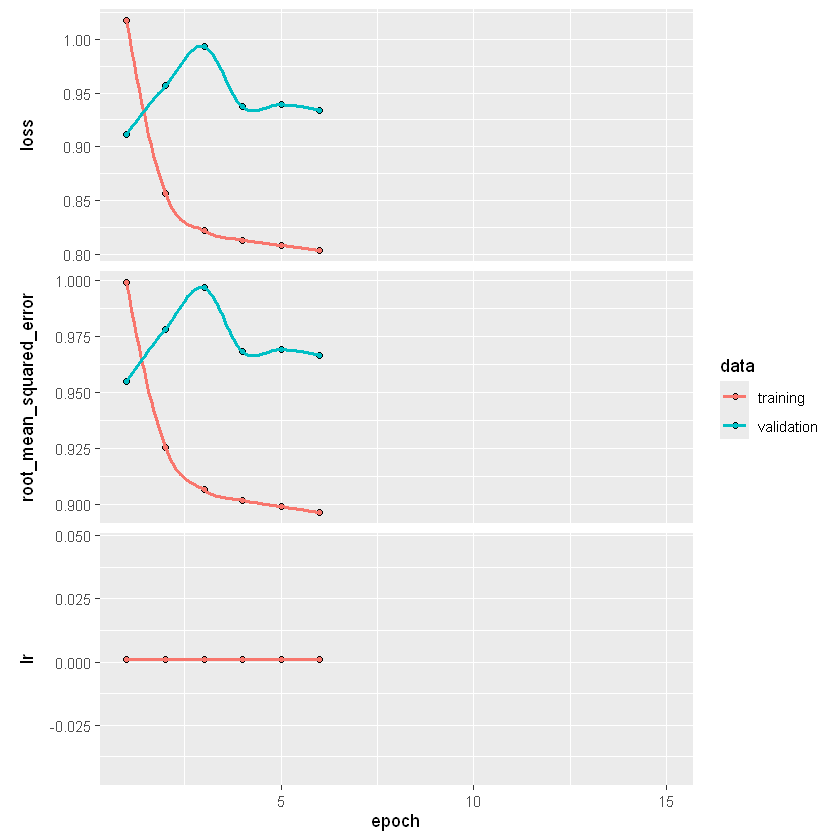

In [39]:
### DEF 2.11.2 Training History Plot ----
plot_history_def <- plot(history_def)
plot_history_def
print(history_df_def)

### DEF 2.11.3 Actual Y vs Predicted hat Y points

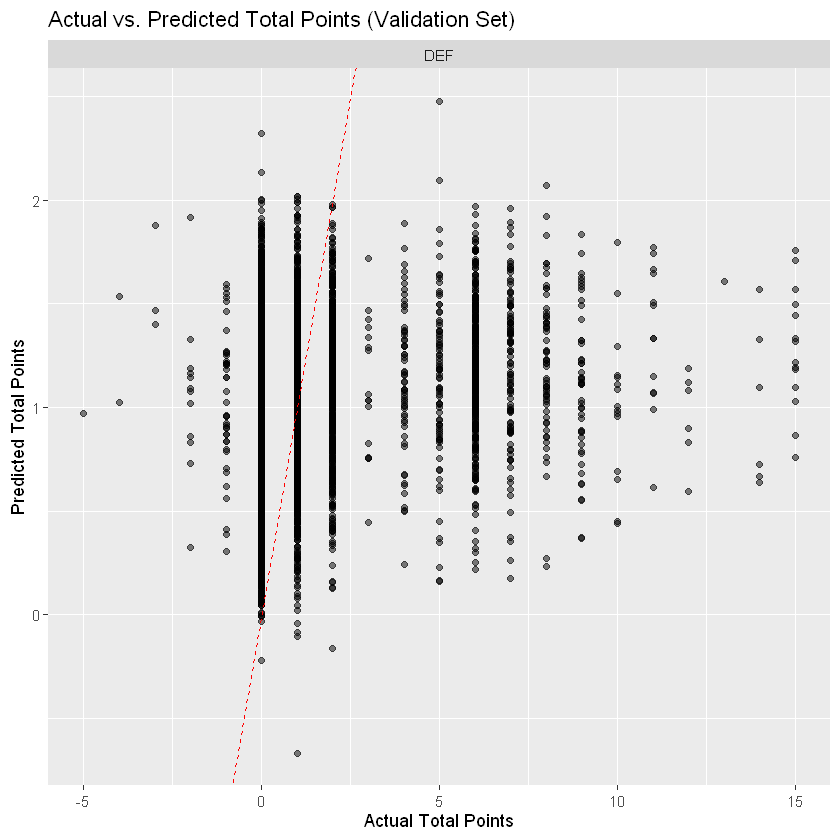

In [40]:
### DEF 2.11.3 Actual Y vs Predicted hat Y points ----
plot_actual_predicted_def <- ggplot(preds_def, aes(x = actual_total_points, y = predicted_total_points)) +
  geom_point(alpha = 0.5) + # Use alpha for transparency if many points overlap
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") + # y=x line
  labs(title = "Actual vs. Predicted Total Points (Validation Set)",
       x = "Actual Total Points",
       y = "Predicted Total Points") +
  facet_wrap(~ position) + # Optional: Separate plots by position
  theme_grey() +
  coord_cartesian(xlim = range(preds_def$actual_total_points, na.rm = TRUE), # Adjust limits if needed
                  ylim = range(preds_def$predicted_total_points, na.rm = TRUE))
plot_actual_predicted_def

### DEF 2.11.4: Residuals vs Predicted

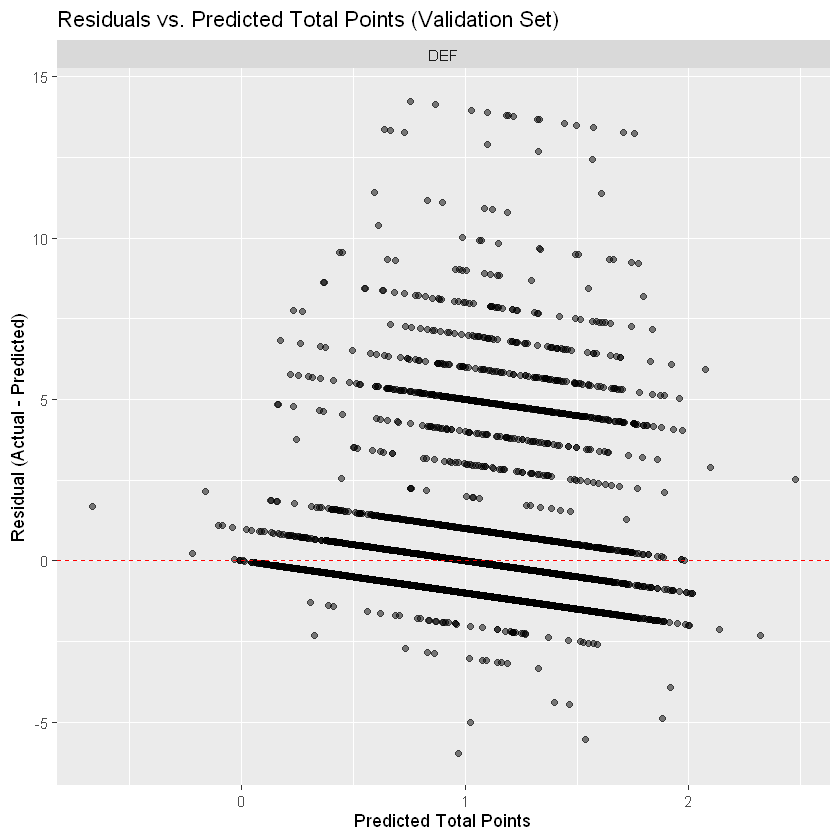

In [41]:
### DEF 2.11.4: Residuals vs Predicted ----

preds_def_residuals <- preds_def # Make copy to add residuals column
preds_def_residuals <- preds_def_residuals %>%
  mutate(residual = actual_total_points - predicted_total_points)

plot_residuals_predicted_def <- ggplot(preds_def_residuals, aes(x = predicted_total_points, y = residual)) +
  geom_point(alpha = 0.5) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") + # Zero error line
  labs(title = "Residuals vs. Predicted Total Points (Validation Set)",
       x = "Predicted Total Points",
       y = "Residual (Actual - Predicted)") +
  facet_wrap(~ position) + # Optional
  theme_grey()
plot_residuals_predicted_def

### DEF 2.11.5: Distribution of Residuals

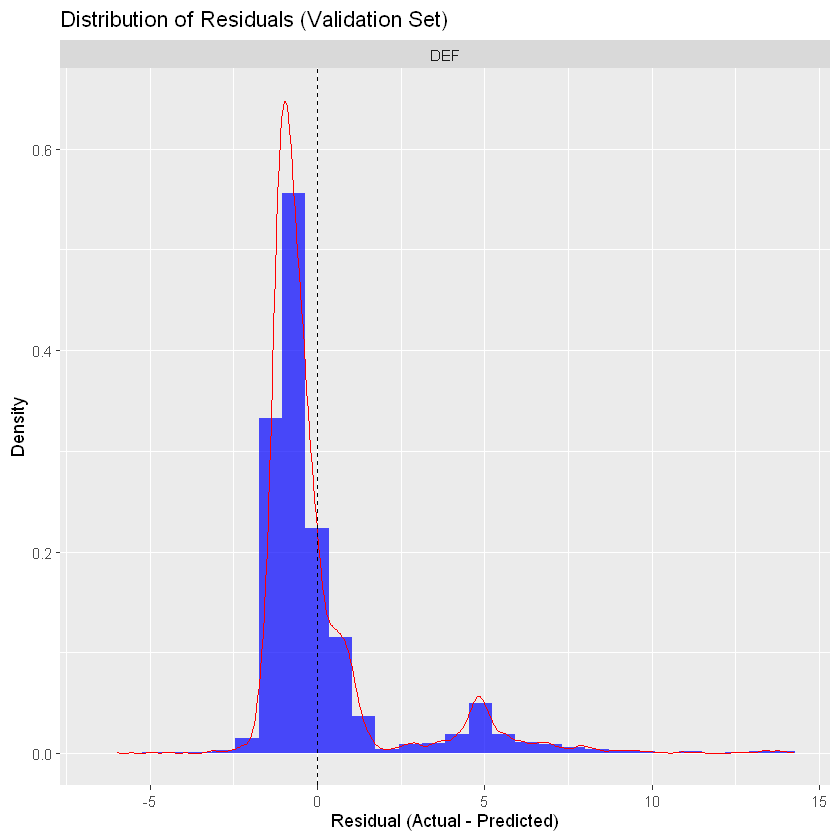

In [42]:
### DEF 2.11.5: Distribution of Residuals ----
plot_distribution_residuals_def <- ggplot(preds_def_residuals, aes(x = residual)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "blue", alpha = 0.7) +
  geom_density(color = "red") +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +
  labs(title = "Distribution of Residuals (Validation Set)",
       x = "Residual (Actual - Predicted)",
       y = "Density") +
  facet_wrap(~ position) + # Optional
  theme_grey()
plot_distribution_residuals_def

### DEF 2.11.6 Return list containing loss value and metrics

In [43]:
### DEF 2.11.6 Return list containing loss value and metrics
# After training, evaluate the model on validation data with all metrics
model_evaluation <- model %>% evaluate(
  x = list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  ),
  y = y_val,
  verbose = 1
)

# Print the evaluation results (metrics specified during compilation)
print(model_evaluation)

# Combine results by position
validation_metrics$def <- model_list$def %>% evaluate(
  x = list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  ),
  y = y_val
)

                   loss root_mean_squared_error 
              0.9118823               0.9549253 


# 3: Midfielders (MID) 

In [ ]:
# 3: Midfielders (MID) ----

## MID 3.1: Define Features, Target & Scale

In [ ]:
## MID 3.1: Define Features, Target & Scale ----

numF <- c("assists", "creativity", "minutes", "goals_conceded",
          "bonus", "bps", "expected_assists", "expected_goal_involvements",
          "expected_goals", "ict_index", "own_goals", "red_cards",
          "threat", "transfers_in", "transfers_out", "yellow_cards",
          "expected_goals_conceded", "value",
          "selected", "transfers_balance", "starts", "influence",
          "clean_sheets")
catF <- c("player_id", "tID", "oID", "hID")
tar <- "total_points"

cat("Numeriske features:", numF, "\n")
cat("Kategoriske features:", catF, "\n")
cat("Target variabel:", tar, "\n")
cat("Ferdig")

# Compute and store the mean and standard deviation for the target variable

mu <- mean(mid[[tar]], na.rm = TRUE)
sigma <- sd(mid[[tar]], na.rm = TRUE)

# Scale numerical features and target
mid <- mid %>%
  mutate(across(all_of(numF), ~ (.x - mean(.x, na.rm = TRUE)) / sd(.x, na.rm = TRUE)),
         !!tar := (.data[[tar]] - mu) / sigma)
cat("Kjørt")

## MID 3.2: Building Rolling Windows

In [ ]:
## MID 3.2: Build Rolling Windows ----
# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- mid %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1, # prevents the model from seeing current gw data
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(mid %>% select(row_id, GW), by = "row_id")
# Build categorical rolling windows (if needed for debugging; here we use only the current values)
catW <- mid %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%
  group_modify(~ {
    df <- ungroup(.x) %>% mutate(player_id = .y$player_id)
    windows <- slide(df %>% select(all_of(catF)),
                     .f = ~ as.matrix(.x),
                     .before = ws,
                     #.after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- df[[tar]][(ws + 1):nrow(df)]
    tibble(window = valid_windows, target = target)
  }) %>%
  ungroup()

cat("Kjørt")

## MID 3.3: Lasso regression

In [ ]:
## MID 3.3: Lasso regression ----

# Check for any NA in the windows before summary
sumna <- sapply(numW$window, function(flatW) any(is.na(flatW)))
cat("Windows with NA: ", sum(sumna), "\n")

# numW as data.matrix, tar as response variable
aggmat <- lapply(numW$window, function(flatW){
  colMeans(flatW, na.rm = TRUE)
})
x <- do.call(rbind, aggmat)
y <- numW$target

# K-fold CV
cvfit <- cv.glmnet(x,y,alpha=1)
minlambda <- cvfit$lambda.min

lassofit <- glmnet(x,y,alpha = 1, lambda = minlambda)

coef_lasso <- as.matrix(coef(lassofit))
numF <- rownames(coef_lasso)[coef_lasso[,1] != 0]
numF <- setdiff(numF, "(Intercept)")
cat("Selected features: ", numF, "\n")

# repeat rolling window, now only containing selected features
# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- mid %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(mid %>% select(row_id, GW), by = "row_id")

## MID 3.4: Convert Rolling Windows to Arrays & Extract Targets

In [ ]:
## MID 3.4: Convert Rolling Windows to Arrays & Extract Targets ----

# Number of samples is the number of rows in numW
nSamp <- nrow(numW)

# Convert numerical windows to a 3D array of shape [nSamp, ws, length(numF)]
num_array <- array(
  unlist(numW$window),
  dim = c(nSamp, ws, length(numF))
)

# Targets (scaled): a matrix with one column
targets <- matrix(as.numeric(numW$target), ncol = 1)

# For categorical inputs, extract the current categorical values from the last row of each window.
# (If your windows were built solely from historical data, the "current" values need to come from the original data.)
# Here, we use the categorical rolling windows and extract the last row:
cat_current <- do.call(rbind, lapply(catW$window, function(mat) mat[nrow(mat), ]))
# Split into separate matrices (each of shape [nSamp, 1])
cat_player_id <- matrix(as.integer(cat_current[, "player_id"]), ncol = 1)
cat_tID <- matrix(as.integer(cat_current[, "tID"]), ncol = 1)
cat_oID <- matrix(as.integer(cat_current[, "oID"]), ncol = 1)
cat_hID <- matrix(as.integer(cat_current[, "hID"]), ncol = 1)

## MID 3.5: Split Data into Training and Validation Sets

In [ ]:
## MID 3.5: Split Data into Training and Validation Sets ----

idx <- which(numW$GW <= split_gw)

# Training data
Xnum_train <- num_array[idx, , , drop = FALSE]
cat_player_id_train <- cat_player_id[idx, , drop = FALSE]
cat_tID_train <- cat_tID[idx, , drop = FALSE]
cat_oID_train <- cat_oID[idx, , drop = FALSE]
cat_hID_train <- cat_hID[idx, , drop = FALSE]
y_train <- targets[idx, , drop = FALSE]

# Validation data
Xnum_val <- num_array[-idx, , , drop = FALSE]
cat_player_id_val <- cat_player_id[-idx, , drop = FALSE]
cat_tID_val <- cat_tID[-idx, , drop = FALSE]
cat_oID_val <- cat_oID[-idx, , drop = FALSE]
cat_hID_val <- cat_hID[-idx, , drop = FALSE]
y_val <- targets[-idx, , drop = FALSE]

# Also, extract the row IDs for the validation samples (for later joining)
val_row_ids <- numW$row_id[-idx]

cat("Cell loaded\n")

## MID 3.6: Building the Keras Neural Network Model 

In [ ]:
## MID 3.6: Building the Keras Neural Network Model ----

cat("Building the Model\n")
# Define maximum values for categorical features
num_players   <- max(mid$player_id)
num_teams     <- max(mid$tID)
num_opponents <- max(mid$oID)

embedding_dimension <- num_embedding_dimension  # Embedding dimension

# Create input layers for current categorical values
input_player_id <- layer_input(shape = c(1), dtype = "int32", name = "input_player_id")
input_tID <- layer_input(shape = c(1), dtype = "int32", name = "input_tID")
input_oID <- layer_input(shape = c(1), dtype = "int32", name = "input_oID")
input_hID <- layer_input(shape = c(1), dtype = "int32", name = "input_hID")

embedding_player_id <- input_player_id %>% 
  layer_embedding(input_dim = num_players + 1, output_dim = embedding_dimension, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_tID <- input_tID %>% 
  layer_embedding(input_dim = num_teams + 1, output_dim = embedding_dimension, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_oID <- input_oID %>% 
  layer_embedding(input_dim = num_opponents + 1, output_dim = embedding_dimension, mask_zero = TRUE) %>% 
  layer_flatten()
# For hID, convert to float32 to match types
input_hID_flat <- input_hID %>% 
  layer_lambda(function(x) tf$cast(x, tf$float32)) %>% 
  layer_flatten()

# Merge categorical branch
cat_merged <- layer_concatenate(list(embedding_player_id, embedding_tID, embedding_oID, input_hID_flat)) %>%
  layer_dense(units = 16, activation = "relu")

# Numerical branch: input for rolling window data
input_seq <- layer_input(shape = c(ws, length(numF)), name = "input_seq")
lstm_branch <- input_seq %>%
  layer_lstm(units = 64, return_sequences = FALSE) %>%
  layer_dropout(rate = 0.2)

# Merge both branches and build the output
merged <- layer_concatenate(list(lstm_branch, cat_merged))
dense_layer <- merged %>% layer_dense(units = 32, activation = "relu")
output <- dense_layer %>% layer_dense(units = 1, activation = "linear")

# Build and compile the model
model <- keras_model(
  inputs = list(input_seq, input_player_id, input_tID, input_oID, input_hID),
  outputs = output,
    name = "mid_lstm_model"
)
model %>% compile(
  optimizer = optimizer_adam(),
  loss = "mse",
  metrics = metrics_regression,
  run_eagerly = TRUE
)

summary(model)
plot(model)

# Access the Python keras module directly
keras_python <- import("keras")

# Generate the plot with your desired parameters
keras_python$utils$plot_model(
  model,
  to_file = "keras-model-mid.png",
  show_shapes = FALSE,  # Set to TRUE to see tensor shapes
  show_dtype = FALSE,
  show_layer_names = TRUE,
  rankdir = "TB",      # "TB" (top to bottom) or "LR" (left to right)
  expand_nested = FALSE,
  dpi = 200,
  show_layer_activations = FALSE
)

# Display the image in R
library(png) # or library(png) depending on your output format
img <- readPNG("keras-model-mid.png") # or readJPEG for jpeg format
grid::grid.raster(img)

## MID 3.7: Setup Weight saving and Callback functions ----

In [ ]:
# Filepath for saving the BEST weights (unique for each position)
weights_filepath_mid <- "R Forecast/best_mid.hdf5"
cat("Will save best MID weights to:", weights_filepath_mid, "\n")

# 1. Early Stopping Callback
early_stopping <- callback_early_stopping(
    monitor = "val_loss",       # Monitor validation loss
    patience = num_patience,              # Stop after 10 epochs of no improvement
    restore_best_weights = TRUE # Optional but good: restores weights from the best epoch at the end of training
                                # Note: Checkpoint callback is the primary saver here.
)

# 2. Model Checkpoint Callback (to save best weights)
model_checkpoint <- callback_model_checkpoint(
    filepath = weights_filepath_mid, # Path defined above
    monitor = "val_loss",           # Monitor the same metric as early stopping
    save_best_only = TRUE,          # IMPORTANT: Only save when val_loss improves
    save_weights_only = TRUE,       # IMPORTANT: Save ONLY the weights, not the whole model
    mode = "min",                   # We want to minimize loss
    verbose = 1                     # Optional: print message when weights are saved
)

reduce_lr <- callback_reduce_lr_on_plateau(
    monitor = "val_loss",  # Monitor validation loss (same as early stopping)
    factor = 0.2,          # Reduce LR to 20% of its current value (lr * factor)
    patience = 5,           # Reduce LR if val_loss doesn't improve for 5 epochs
    min_lr = 1e-6,         # Don't reduce the LR below this value
    verbose = 1            # Print a message when LR is reduced
)

# Store scaling factors NOW (before potential errors during training)
# Ensure mu, sigma, and numF (Lasso selected) are correctly captured from the GK scaling steps
scaling_factors$mid <- list(
    mu = mu,         # Mean of GK target used for scaling
    sigma = sigma,   # SD of GK target used for scaling
    numF = numF      # Vector of Lasso-selected numerical feature names for GK
)
cat("MID scaling factors stored.\n")

## MID 3.8: Train Midfield LSTM Model

In [ ]:
## MID 3.8: Train Midfield LSTM Model ----

cat("Starting MID model training...\n")
history <- model %>% fit(
  x = list(
    input_seq = Xnum_train,
    input_player_id = cat_player_id_train,
    input_tID = cat_tID_train,
    input_oID = cat_oID_train,
    input_hID = cat_hID_train
  ),
  y = y_train,
  epochs = epoker,          # Max epochs
  batch_size = 64,          # Try increasing batch size (e.g., 64 or 128) for speed
  validation_data = list(
    list(
      input_seq = Xnum_val,
      input_player_id = cat_player_id_val,
      input_tID = cat_tID_val,
      input_oID = cat_oID_val,
      input_hID = cat_hID_val
    ),
    y_val
  ),
  # ADD THE CALLBACKS HERE
  callbacks = list(early_stopping, model_checkpoint, reduce_lr)
)
cat("MID model training finished.\n")

## MID 3.9: Generate Predictions & Invert Scaling on Validation Set

In [ ]:
## MID 3.9: Generate Predictions & Invert Scaling on Validation Set ----

# Use the validation set for predictions
pred_all <- model %>% predict(
  list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  )
)

# Build a predictions table using the validation row IDs
preds_mid <- tibble(
  row_id = val_row_ids,  # row IDs corresponding to the validation set
  predicted_total_points_scaled = as.vector(pred_all),
  actual_total_points_scaled = as.vector(y_val)
) %>% 
  mutate(
    predicted_total_points = predicted_total_points_scaled * sigma + mu,
    actual_total_points = actual_total_points_scaled * sigma + mu
  )

preds_mid <- preds_mid %>%
  left_join(unscaled_mid, by = "row_id") # Use unscaled_mid

# View the predictions table
glimpse(preds_mid)

## MID 3.10: Save model and validation set predictions

In [ ]:
## MID 3.10: Save model and validation set predictions ----
# Store MID model and scaling factors
model_list$mid <- model
scaling_factors$mid <- list(mu = mu, sigma = sigma, numF = numF) # numF here is the one selected by Lasso for MID
cat("MID model and scaling factors stored.\n")

# Clean up validation predictions (select essential columns)
# Note: The join in cell a38dc192 uses 'mid' (scaled) then 'unscaled_mid'.
preds_mid_clean <- preds_mid %>%
   select(row_id, GW, player_id, name, position, team, # Identifiers from unscaled_mid join
         actual_total_points, predicted_total_points, value)

## MID 3.11: Plots for Evaluation

In [ ]:
## MID 3.11: Plots for Evaluation ----

### MID 3.11.1 Save training and fit history

In [ ]:
### MID 3.11.1 Save training and fit history ----
history_mid <- history #class() "keras_training_history"
history_df_mid <- data.frame(history_mid)

### MID 3.11.2 Training History Plot

In [ ]:
### MID 3.11.2 Training History Plot
plot_history_mid<- plot(history_mid)
plot_history_mid
print(history_df_mid)

### MID 3.11.3 Actual Y vs Predicted hat Y points

In [ ]:
### MID 3.11.4: Residuals vs Predicted ----
preds_mid_residuals <- preds_mid # Make copy to add residuals column
preds_mid_residuals <- preds_mid_residuals %>%
  mutate(residual = actual_total_points - predicted_total_points)

plot_residuals_predicted_mid <- ggplot(preds_mid_residuals, aes(x = predicted_total_points, y = residual)) +
  geom_point(alpha = 0.5) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") + # Zero error line
  labs(title = "Residuals vs. Predicted Total Points (Validation Set)",
       x = "Predicted Total Points",
       y = "Residual (Actual - Predicted)") +
  facet_wrap(~ position) + # Optional
  theme_grey()
plot_residuals_predicted_mid

### MID 3.11.5: Distribution of Residuals

In [ ]:
### MID 3.11.5: Distribution of Residuals ----
plot_distribution_residuals_mid <- ggplot(preds_mid_residuals, aes(x = residual)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "blue", alpha = 0.7) +
  geom_density(color = "red") +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +
  labs(title = "Distribution of Residuals (Validation Set)",
       x = "Residual (Actual - Predicted)",
       y = "Density") +
  facet_wrap(~ position) + # Optional
  theme_grey()
plot_distribution_residuals_mid 

### MID 3.11.6 Return list containing loss value and metrics

In [ ]:
### MID 3.11.6 Return list containing loss value and metrics ----

# After training, evaluate the model on validation data with all metrics
model_evaluation <- model %>% evaluate(
  x = list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  ),
  y = y_val,
  verbose = 1
)

# Print the evaluation results (metrics specified during compilation)
print(model_evaluation)

# Combine results by position
validation_metrics$mid <- model_list$mid %>% evaluate(
  x = list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  ),
  y = y_val
)

# 4: Forwards

In [ ]:
# 4: Forwards ----

## FWD 4.1 Define Features, Target & Scale

In [ ]:
## FWD 4.1 Define Features, Target & Scale ----

numF <- c("assists", "creativity", "minutes", "goals_conceded",
          "bonus", "bps", "expected_assists", "expected_goal_involvements",
          "expected_goals", "ict_index", "own_goals", "red_cards",
          "threat", "transfers_in", "transfers_out", "yellow_cards",
          "expected_goals_conceded", "value",
          "selected", "transfers_balance", "starts", "influence",
          "clean_sheets")
catF <- c("player_id", "tID", "oID", "hID")
tar <- "total_points"

cat("Numeriske features:", numF, "\n")
cat("Kategoriske features:", catF, "\n")
cat("Target variabel:", tar, "\n")
cat("Ferdig")
# numF, catF og tar variablene brukes på nytt
# Compute and store the mean and standard deviation for the target variable
mu <- mean(fwd[[tar]], na.rm = TRUE)
sigma <- sd(fwd[[tar]], na.rm = TRUE)

# Scale numerical features and target
fwd <- fwd %>%
  mutate(across(all_of(numF), ~ (.x - mean(.x, na.rm = TRUE)) / sd(.x, na.rm = TRUE)),
         !!tar := (.data[[tar]] - mu) / sigma)

cat("Chunk Done\n")

## FWD 4.2 Building rolling windows

In [ ]:
## FWD 4.2 Building rolling windows ----

# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- fwd %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1, # prevents the model from seeing current gw data
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()
numW <- numW %>%
  left_join(fwd %>% select(row_id, GW), by = "row_id")
# Build categorical rolling windows (if needed for debugging; here we use only the current values)
catW <- fwd %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%
  group_modify(~ {
    df <- ungroup(.x) %>% mutate(player_id = .y$player_id)
    windows <- slide(df %>% select(all_of(catF)),
                     .f = ~ as.matrix(.x),
                     .before = ws,
                     #.after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- df[[tar]][(ws + 1):nrow(df)]
    tibble(window = valid_windows, target = target)
  }) %>%
  ungroup()

cat("Chunk done\n")

## FWD 4.3: Lasso regression

In [ ]:
## FWD 4.3: Lasso regression ----

# Check for any NA in the windows before summary
sumna <- sapply(numW$window, function(flatW) any(is.na(flatW)))
cat("Windows with NA: ", sum(sumna), "\n")

# numW as data.matrix, tar as response variable

aggmat <- lapply(numW$window, function(flatW){
  colMeans(flatW, na.rm = TRUE)
})
x <- do.call(rbind, aggmat)
y <- numW$target

# K-fold CV
cvfit <- cv.glmnet(x,y,alpha=1)
minlambda <- cvfit$lambda.min

lassofit <- glmnet(x,y,alpha = 1, lambda = minlambda)

coef_lasso <- as.matrix(coef(lassofit))
numF <- rownames(coef_lasso)[coef_lasso[,1] != 0]
numF <- setdiff(numF, "(Intercept)")
cat("Selected features: ", numF, "\n")

# repeat rolling window, now only containing selected features
# Define window size (number of past gameweeks to use)
ws <- vindu

# Build numerical rolling windows
numW <- fwd %>%
  group_by(player_id) %>%
  filter(n() > ws) %>%  # Only players with more than ws observations
  group_modify(~ {
    windows <- slide(.x[, numF],
                     .f = ~ as.matrix(.x),
                     .before = ws, 
                     .after = -1,
                     .complete = TRUE)
    valid_windows <- windows[(ws + 1):length(windows)]
    target <- .x[[tar]][(ws + 1):nrow(.x)]
    # Extract row_id for each valid window
    rid <- .x$row_id[(ws + 1):nrow(.x)]
    tibble(window = valid_windows, target = target, row_id = rid)
  }) %>%
  ungroup()

numW <- numW %>%
  left_join(fwd %>% select(row_id, GW), by = "row_id")

## FWD 4.4: Convert Rolling Windows

In [ ]:
## FWD 4.4: Convert Rolling Windows ----

# Number of samples is the number of rows in numW
nSamp <- nrow(numW)

# Convert numerical windows to a 3D array of shape [nSamp, ws, length(numF)]
num_array <- array(
  unlist(numW$window),
  dim = c(nSamp, ws, length(numF))
)

# Targets (scaled): a matrix with one column
targets <- matrix(as.numeric(numW$target), ncol = 1)

# For categorical inputs, extract the current categorical values from the last row of each window.
# (If your windows were built solely from historical data, the "current" values need to come from the original data.)
# Here, we use the categorical rolling windows and extract the last row:
cat_current <- do.call(rbind, lapply(catW$window, function(mat) mat[nrow(mat), ]))
# Split into separate matrices (each of shape [nSamp, 1])
cat_player_id <- matrix(as.integer(cat_current[, "player_id"]), ncol = 1)
cat_tID <- matrix(as.integer(cat_current[, "tID"]), ncol = 1)
cat_oID <- matrix(as.integer(cat_current[, "oID"]), ncol = 1)
cat_hID <- matrix(as.integer(cat_current[, "hID"]), ncol = 1)

cat("Chunk done\n")

## FWD 4.5: Split Data into Training and Validation Sets

In [ ]:
## FWD 4.5: Split Data into Training and Validation Sets ----

idx <- which(numW$GW <= split_gw)

# Training data
Xnum_train <- num_array[idx, , , drop = FALSE]
cat_player_id_train <- cat_player_id[idx, , drop = FALSE]
cat_tID_train <- cat_tID[idx, , drop = FALSE]
cat_oID_train <- cat_oID[idx, , drop = FALSE]
cat_hID_train <- cat_hID[idx, , drop = FALSE]
y_train <- targets[idx, , drop = FALSE]

# Validation data
Xnum_val <- num_array[-idx, , , drop = FALSE]
cat_player_id_val <- cat_player_id[-idx, , drop = FALSE]
cat_tID_val <- cat_tID[-idx, , drop = FALSE]
cat_oID_val <- cat_oID[-idx, , drop = FALSE]
cat_hID_val <- cat_hID[-idx, , drop = FALSE]
y_val <- targets[-idx, , drop = FALSE]

# Also, extract the row IDs for the validation samples (for later joining)
val_row_ids <- numW$row_id[-idx]
cat("Chunk FWD 4.4 done")

## FWD 4.6: Building the Keras Neural Network Model 

In [ ]:
## FWD 4.6: Building the Keras Neural Network Model ----

# Define maximum values for categorical features
num_players   <- max(fwd$player_id)
num_teams     <- max(fwd$tID)
num_opponents <- max(fwd$oID)

embedding_dimension <- num_embedding_dimension  # Embedding dimension

# Create input layers for current categorical values
input_player_id <- layer_input(shape = c(1), dtype = "int32", name = "input_player_id")
input_tID <- layer_input(shape = c(1), dtype = "int32", name = "input_tID")
input_oID <- layer_input(shape = c(1), dtype = "int32", name = "input_oID")
input_hID <- layer_input(shape = c(1), dtype = "int32", name = "input_hID")

embedding_player_id <- input_player_id %>% 
  layer_embedding(input_dim = num_players + 1, output_dim = embedding_dimension, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_tID <- input_tID %>% 
  layer_embedding(input_dim = num_teams + 1, output_dim = embedding_dimension, mask_zero = TRUE) %>% 
  layer_flatten()
embedding_oID <- input_oID %>% 
  layer_embedding(input_dim = num_opponents + 1, output_dim = embedding_dimension, mask_zero = TRUE) %>% 
  layer_flatten()
# For hID, convert to float32 to match types
input_hID_flat <- input_hID %>% 
  layer_lambda(function(x) tf$cast(x, tf$float32)) %>% 
  layer_flatten()

# Merge categorical branch
cat_merged <- layer_concatenate(list(embedding_player_id, embedding_tID, embedding_oID, input_hID_flat)) %>%
  layer_dense(units = 16, activation = "relu")

# Numerical branch: input for rolling window data
input_seq <- layer_input(shape = c(ws, length(numF)), name = "input_seq")
lstm_branch <- input_seq %>%
  layer_lstm(units = 64, return_sequences = FALSE) %>%
  layer_dropout(rate = 0.2)

# Merge both branches and build the output
merged <- layer_concatenate(list(lstm_branch, cat_merged))
dense_layer <- merged %>% layer_dense(units = 32, activation = "relu")
output <- dense_layer %>% layer_dense(units = 1, activation = "linear")

# Build and compile the model
model <- keras_model(
  inputs = list(input_seq, input_player_id, input_tID, input_oID, input_hID),
  outputs = output,
    name = "fwd_lstm_model"
)
model %>% compile(
  optimizer = optimizer_adam(),
  loss = "mse",
  metrics = metrics_regression,
  run_eagerly = TRUE
)

summary(model)
plot(model)

# Access the Python keras module directly
keras_python <- import("keras")

# Generate the plot with your desired parameters
keras_python$utils$plot_model(
  model,
  to_file = "keras-model-fwd.png",
  show_shapes = FALSE,  # Set to TRUE to see tensor shapes
  show_dtype = FALSE,
  show_layer_names = TRUE,
  rankdir = "TB",      # "TB" (top to bottom) or "LR" (left to right)
  expand_nested = FALSE,
  dpi = 200,
  show_layer_activations = FALSE
)

# Display the image in R
library(png) # or library(png) depending on your output format
img <- readPNG("keras-model-fwd.png") # or readJPEG for jpeg format
grid::grid.raster(img)

## FWD 4.7: Callback Functions and Scaling Factors

In [ ]:
## FWD 4.7: Callback Functions and Scaling Factors ----

# Filepath for saving the BEST weights (unique for each position)
weights_filepath_fwd <- "R Forecast/best_fwd_weights.hdf5"
cat("Will save best FWD weights to:", weights_filepath_fwd, "\n")

# 1. Early Stopping Callback
early_stopping <- callback_early_stopping(
    monitor = "val_loss",       # Monitor validation loss
    patience = num_patience,              # Stop after 10 epochs of no improvement
    restore_best_weights = TRUE # Optional but good: restores weights from the best epoch at the end of training
                                # Note: Checkpoint callback is the primary saver here.
)

# 2. Model Checkpoint Callback (to save best weights)
model_checkpoint <- callback_model_checkpoint(
    filepath = weights_filepath_fwd, # Path defined above
    monitor = "val_loss",           # Monitor the same metric as early stopping
    save_best_only = TRUE,          # IMPORTANT: Only save when val_loss improves
    save_weights_only = TRUE,       # IMPORTANT: Save ONLY the weights, not the whole model
    mode = "min",                   # We want to minimize loss
    verbose = 1                     # Optional: print message when weights are saved
)

reduce_lr <- callback_reduce_lr_on_plateau(
    monitor = "val_loss",  # Monitor validation loss (same as early stopping)
    factor = 0.2,          # Reduce LR to 20% of its current value (lr * factor)
    patience = 5,           # Reduce LR if val_loss doesn't improve for 5 epochs
    min_lr = 1e-6,         # Don't reduce the LR below this value
    verbose = 1            # Print a message when LR is reduced
)

# Store scaling factors NOW (before potential errors during training)
# Ensure mu, sigma, and numF (Lasso selected) are correctly captured from the FWD scaling steps
scaling_factors$fwd <- list(
    mu = mu,         # Mean of FWD target used for scaling
    sigma = sigma,   # SD of FWD target used for scaling
    numF = numF      # Vector of Lasso-selected numerical feature names for FWD
)
cat("FWD scaling factors stored.\n")

## FWD 4.8: Train Forwards LSTM Model

In [ ]:
## FWD 4.8: Train Forwards LSTM Model ----

cat("Starting FWD model training...\n")
history <- model %>% fit(
  x = list(
    input_seq = Xnum_train,
    input_player_id = cat_player_id_train,
    input_tID = cat_tID_train,
    input_oID = cat_oID_train,
    input_hID = cat_hID_train
  ),
  y = y_train,
  epochs = epoker,          # Max epochs
  batch_size = 64,          # Try increasing batch size (e.g., 64 or 128) for speed
  validation_data = list(
    list(
      input_seq = Xnum_val,
      input_player_id = cat_player_id_val,
      input_tID = cat_tID_val,
      input_oID = cat_oID_val,
      input_hID = cat_hID_val
    ),
    y_val
  ),
  # ADD THE CALLBACKS HERE
  callbacks = list(early_stopping, model_checkpoint, reduce_lr)
)
cat("FWD model training finished.\n")

## FDW 4.9: Generate Predictions & Invert Scaling on Validation Set

In [ ]:
## FDW 4.9: Generate Predictions & Invert Scaling on Validation Set ----

# Use the validation set for predictions
pred_all <- model %>% predict(
  list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  )
)

# Build a predictions table using the validation row IDs
preds_fwd <- tibble(
  row_id = val_row_ids,  # row IDs corresponding to the validation set
  predicted_total_points_scaled = as.vector(pred_all),
  actual_total_points_scaled = as.vector(y_val)
) %>% 
  mutate(
    predicted_total_points = predicted_total_points_scaled * sigma + mu,
    actual_total_points = actual_total_points_scaled * sigma + mu
  )

preds_fwd <- preds_fwd %>%
  left_join(unscaled_fwd, by = "row_id") # Use unscaled_mid

glimpse(preds_fwd)

## FWD 4.10: Save model and validation set predictions

In [ ]:
## FWD 4.10: Save model and validation set predictions ----
# Store FWD model and scaling factors
model_list$fwd <- model
cat("FWD model and scaling factors stored.\n")

# Clean up validation predictions (select essential columns)
preds_fwd_clean <- preds_fwd %>%
   select(row_id, GW , player_id , name, position, team, # Identifiers from unscaled_fwd join
         actual_total_points, predicted_total_points, value)
cat("Validation Predictions stored in preds_fwd_clean.\n")

## FWD 4.11: Plots for Evaluation

In [ ]:
## FWD 4.11: Plots for Evaluation ----

### FWD 4.11.1 Save training and fit history

In [ ]:
### FWD 4.11.1 Save training and fit history ----
history_fwd <- history #class() "keras_training_history"
history_df_fwd <- data.frame(history_fwd)

### FWD 4.11.2 Training History Plot

In [ ]:
### FWD 4.11.2 Training History Plot ----
plot_history_fwd <- plot(history_fwd)
plot_history_fwd
print(history_df_fwd)

### FWD 4.11.3 Actual Y vs Predicted hat Y points

In [ ]:
### FWD 4.11.3 Actual Y vs Predicted hat Y points ----
plot_actual_predicted_fwd <- ggplot(preds_fwd, aes(x = actual_total_points, y = predicted_total_points)) +
  geom_point(alpha = 0.5) + # Use alpha for transparency if many points overlap
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") + # y=x line
  labs(title = "Actual vs. Predicted Total Points (Validation Set)",
       x = "Actual Total Points",
       y = "Predicted Total Points") +
  facet_wrap(~ position) + # Optional: Separate plots by position
  theme_grey() +
  coord_cartesian(xlim = range(preds_fwd$actual_total_points, na.rm = TRUE), # Adjust limits if needed
                  ylim = range(preds_fwd$predicted_total_points, na.rm = TRUE))
plot_actual_predicted_fwd    

### FWD 4.11.4: Residuals vs Predicted

In [ ]:
### FWD 4.11.4: Residuals vs Predicted ----

preds_fwd_residuals <- preds_fwd # Make copy to add residuals column
preds_fwd_residuals <- preds_fwd_residuals %>%
  mutate(residual = actual_total_points - predicted_total_points)

plot_residuals_predicted_fwd <- ggplot(preds_fwd_residuals, aes(x = predicted_total_points, y = residual)) +
  geom_point(alpha = 0.5) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") + # Zero error line
  labs(title = "Residuals vs. Predicted Total Points (Validation Set)",
       x = "Predicted Total Points",
       y = "Residual (Actual - Predicted)") +
  facet_wrap(~ position) + # Optional
  theme_grey()  
plot_residuals_predicted_fwd

### FWD 4.11.5: Distribution of Residuals

In [ ]:
### FWD 4.11.5: Distribution of Residuals ----
plot_distribution_residuals_fwd <- ggplot(preds_fwd_residuals, aes(x = residual)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "blue", alpha = 0.7) +
  geom_density(color = "red") +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +
  labs(title = "Distribution of Residuals (Validation Set)",
       x = "Residual (Actual - Predicted)",
       y = "Density") +
  facet_wrap(~ position) + # Optional
  theme_grey()
plot_distribution_residuals_fwd

### FWD 4.11.6 Return list containing loss value and metrics

In [ ]:
### FWD 4.11.6 Return list containing loss value and metrics ----
# After training, evaluate the model on validation data with all metrics
model_evaluation <- model %>% evaluate(
  x = list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  ),
  y = y_val,
  verbose = 1
)

# Print the evaluation results (metrics specified during compilation)
print(model_evaluation)

# Combine results by position
validation_metrics$fwd <- model_list$fwd %>% evaluate(
  x = list(
    input_seq = Xnum_val,
    input_player_id = cat_player_id_val,
    input_tID = cat_tID_val,
    input_oID = cat_oID_val,
    input_hID = cat_hID_val
  ),
  y = y_val
)

# Merging Datasets

In [ ]:
# Merging Datasets ----
glimpse(preds_gk)
glimpse(preds_def)
glimpse(preds_mid)
glimpse(preds_fwd)

# filepath: c:\Users\peram\Documents\test\R Forecast\prognose-modell.ipynb
# Combine the CLEANED validation predictions
validation_results_df <- bind_rows(
    preds_gk_clean,
    preds_def_clean,
    preds_mid_clean,
    preds_fwd_clean
  ) %>%
  arrange(player_id, GW)

glimpse(validation_results_df)

# Keep the original detailed forecast df as well (optional)
forecastdf_detailed <- bind_rows(preds_gk, preds_def, preds_mid, preds_fwd)
cat("Clean and detailed validation results combined.\n")

## Evaluation Metrics Dataframe

In [ ]:
## Evaluation Metrics Dataframe ----
# Create metrics comparison dataframe
metrics_df <- data.frame(
  metric = names(validation_metrics$gk),
  GK = unlist(validation_metrics$gk),
  DEF = unlist(validation_metrics$def),
  MID = unlist(validation_metrics$mid),
  FWD = unlist(validation_metrics$fwd)
)

metrics_df

# Plots


## Export Predicted Validation Set as .CSV

In [ ]:
## Export Predicted Validation Set as .CSV ----
# Export CLEAN validation results
write_csv(validation_results_df, "Validation_Predictions_Clean.csv")
cat("Clean validation predictions saved to Validation_Predictions_Clean.csv\n")

# Export DETAILED validation results (original behavior, renamed file)
write_csv(forecastdf_detailed, "Validation_Predictions_Detailed.csv")
cat("Detailed validation predictions saved to Validation_Predictions_Detailed.csv\n")

# Make further predictions
To do this we need future fixtures including:
- GW (gameweek number)
- team_id (team identifier matching your tID)
- opponent_id (opponent identifier matching your oID)
- is_home (1 for home, 0 for away)

In [ ]:
# Make further predictions ----
# To do this we need future fixtures including:
# - GW (gameweek number)
# - team_id (team identifier matching your tID)
# - opponent_id (opponent identifier matching your oID)
# - is_home (1 for home, 0 for away)

## Helper functions:

In [ ]:
## Helper functions: ----

### Get FPL fixtures

In [ ]:
### Get FPL fixtures ----

In [ ]:
# Funksjon som henter fra api
# Function to get fixtures from FPL API
get_fpl_fixtures <- function() {
  # Make API request
  response <- GET("https://fantasy.premierleague.com/api/fixtures/")
  
  # Check if request was successful
  if (http_status(response)$category != "Success") {
    stop("Failed to fetch fixtures from FPL API. Status code: ", status_code(response))
  }
  
  # Parse JSON response
  fixtures_json <- content(response, "text", encoding = "UTF-8")
  fixtures_data <- fromJSON(fixtures_json, flatten = TRUE)
  
  # Basic transformation to required format
  formatted_fixtures <- tibble(
    GW = fixtures_data$event,
    home_team_id = fixtures_data$team_h,
    away_team_id = fixtures_data$team_a,
    kickoff_time = fixtures_data$kickoff_time
  ) %>%
    # Filter out fixtures with no scheduled gameweek (NULL or NA values)
    filter(!is.na(GW)) %>%
    # Create the same format as your previous code
    transmute(
      GW = GW,
      # Create a row for home team
      team_id = home_team_id,
      opponent_id = away_team_id,
      is_home = 1
    ) %>%
    # Also create corresponding away team rows
    bind_rows(
      tibble(
        GW = fixtures_data$event,
        home_team_id = fixtures_data$team_h,
        away_team_id = fixtures_data$team_a
      ) %>%
        filter(!is.na(GW)) %>%
        transmute(
          GW = GW,
          team_id = away_team_id,
          opponent_id = home_team_id,
          is_home = 0
        )
    )
  
  # Convert team IDs to match your internal team IDs if needed
  # This depends on how your team IDs are structured compared to FPL's
  # You might need to create a mapping table
  
  return(formatted_fixtures)
}

future_fixtures <- get_fpl_fixtures()
future_fixtures

### Hente lag id til lag funksjon

In [ ]:
# Function to get team mapping from FPL API
get_team_mapping <- function() {
  # Make API request to bootstrap-static endpoint which contains team data
  response <- GET("https://fantasy.premierleague.com/api/bootstrap-static/")
  
  # Check if request was successful
  if (http_status(response)$category != "Success") {
    stop("Failed to fetch bootstrap data from FPL API. Status code: ", status_code(response))
  }
  
  # Parse JSON response
  bootstrap_json <- content(response, "text", encoding = "UTF-8")
  bootstrap_data <- fromJSON(bootstrap_json, flatten = TRUE)
  
  # Extract team data
  team_mapping <- tibble(
    team_id = bootstrap_data$teams$id,
    team_name = bootstrap_data$teams$name,
    team_short_name = bootstrap_data$teams$short_name
  )
  
  return(team_mapping)
}

team_mapping <- get_team_mapping()

## Prognosering

In [ ]:
if (exists("future_fixtures")) {
  print(paste("Max GW in future_fixtures:", max(future_fixtures$GW, na.rm = TRUE)))
  print("Gameweeks present in future_fixtures:")
  print(table(future_fixtures$GW))
  glimpse(future_fixtures)
} else {
  print("future_fixtures data frame does not exist.")
}

In [ ]:
num_previous_full_seasons <- 2 # Set this correctly
# --- End User Input ---

# 1. Determine Starting GWs (Historical and API)
#--------------------------------------------
if (!exists("alternativsammensatt") || !("GW" %in% names(alternativsammensatt))) {
  stop("The 'alternativsammensatt' dataframe is missing or does not contain the 'GW' column.")
}
last_historical_gw <- max(alternativsammensatt$GW, na.rm = TRUE)
current_api_gw <- last_historical_gw - (num_previous_full_seasons * 38)
target_api_gws <- (current_api_gw + 1):(current_api_gw + antall_uker)

cat("Last Historical GW in data:", last_historical_gw, "\n")
cat("Corresponding Current API GW:", current_api_gw, "\n")
cat("Forecasting for API GWs:", paste(target_api_gws, collapse = ", "), "\n")

if (any(target_api_gws > 38)) {
    cat("WARNING: Target API GWs exceed 38. Ensure 'future_fixtures' contains data for the next season if applicable.\n")
}
if (any(target_api_gws < 1)) {
    stop("Calculated target API GWs are less than 1. Check 'num_previous_full_seasons' calculation.")
}

# 2. Get Fixtures for Future API Gameweeks
#--------------------------------------------
if (!exists("future_fixtures") || !all(c("GW", "team_id", "opponent_id", "is_home") %in% names(future_fixtures))) {
  stop("The 'future_fixtures' dataframe is missing or does not have the required columns (GW, team_id, opponent_id, is_home). It should use API GW numbering (1-38).")
}
future_fixtures_filtered <- future_fixtures %>%
  filter(GW %in% target_api_gws) %>%
  mutate(across(c(team_id, opponent_id), as.integer))

if (nrow(future_fixtures_filtered) == 0) {
    stop("No API fixture data found for the target API gameweeks: ", paste(target_api_gws, collapse=", "))
}
cat("Fixture data loaded for target API GWs.\n")

# 3. Prepare Base Input Data (Once per position)
#--------------------------------------------
base_input_list <- list()
all_player_metadata <- list()

for (pos in c("gk", "def", "mid", "fwd")) {
  cat("\n--- Preparing base input for position:", toupper(pos), "---\n")
  if (!pos %in% names(model_list)) { cat("   Skipping: Model not found for", pos, "\n"); next }
  if (!pos %in% names(scaling_factors)) { cat("   Skipping: Scaling factors not found for", pos, "\n"); next }
  current_model <- model_list[[pos]]
  current_mu <- scaling_factors[[pos]]$mu
  current_sigma <- scaling_factors[[pos]]$sigma
  current_numF <- scaling_factors[[pos]]$numF
  if (!exists(pos)) { cat("   Skipping: Scaled data frame '", pos, "' not found.\n"); next }
  if (!exists(paste0("unscaled_", pos))) { cat("   Skipping: Unscaled data frame 'unscaled_", pos, "' not found.\n"); next }
  scaled_data <- get(pos)
  unscaled_data_minimal <- get(paste0("unscaled_", pos)) %>%
                           distinct(player_id, name, position, team, value)
  all_player_metadata[[pos]] <- unscaled_data_minimal
  active_players_pos <- scaled_data %>%
    filter(GW == last_historical_gw) %>%
    distinct(player_id, tID) %>%
    mutate(across(c(player_id, tID), as.integer))
  if (nrow(active_players_pos) == 0) {
    cat("   No active players found for", toupper(pos), "in Historical GW", last_historical_gw, ". Skipping.\n")
    next
  }
  base_input_data_pos <- scaled_data %>%
    filter(player_id %in% active_players_pos$player_id) %>%
    group_by(player_id) %>%
    arrange(GW) %>%
    slice_tail(n = vindu) %>%
    filter(n() == vindu) %>%
    ungroup()
  players_with_history <- base_input_data_pos %>% distinct(player_id)
  active_players_pos <- active_players_pos %>% filter(player_id %in% players_with_history$player_id)
  n_forecast_pos <- nrow(active_players_pos)
  if (n_forecast_pos == 0) {
    cat("   No players with sufficient history (\", vindu, \"GWs) found for\", toupper(pos), \". Skipping.\n")
    next
  }
  cat("   Base input data prepared for", n_forecast_pos, "players based on data up to Historical GW", last_historical_gw, ".\n")
  num_list <- base_input_data_pos %>%
    select(player_id, all_of(current_numF)) %>%
    arrange(match(player_id, active_players_pos$player_id)) %>%
    group_by(player_id) %>%
    group_split(.keep = FALSE) %>%
    lapply(as.matrix)
  base_num_array_pos <- array(
    unlist(num_list),
    dim = c(n_forecast_pos, vindu, length(current_numF))
  )
  base_cat_player_id_pos <- matrix(as.integer(active_players_pos$player_id), ncol = 1)
  base_cat_tID_pos <- matrix(as.integer(active_players_pos$tID), ncol = 1)
  base_input_list[[pos]] <- list(
      active_players = active_players_pos,
      num_array = base_num_array_pos,
      cat_player_id = base_cat_player_id_pos,
      cat_tID = base_cat_tID_pos,
      mu = current_mu,
      sigma = current_sigma
  )
}
all_player_metadata_df <- bind_rows(all_player_metadata) %>% distinct(player_id, .keep_all = TRUE)

# 4. Forecast Loop (Predicting for each fixture in target GWs)
#--------------------------------------------
all_fixture_forecasts_list <- list() # Store predictions PER FIXTURE

for (gw_api_to_predict in target_api_gws) {
    cat("\n--- Forecasting for API GW:", gw_api_to_predict, "---\n")
    future_fixtures_gw <- future_fixtures_filtered %>% filter(GW == gw_api_to_predict)
    if (nrow(future_fixtures_gw) == 0) {
        cat("   WARNING: No fixture data found for API GW", gw_api_to_predict, ". Skipping this GW.\n")
        next
    }

    forecasts_this_gw_list <- list()

    for (pos in names(base_input_list)) {
        cat("      Forecasting position:", toupper(pos), "\n")
        base_inputs <- base_input_list[[pos]]
        current_model <- model_list[[pos]]

        # Prepare inputs for *each fixture* this GW for active players in this position
        fixture_inputs_gw_pos <- base_inputs$active_players %>%
          inner_join(future_fixtures_gw, by = c("tID" = "team_id"), relationship = "many-to-many") %>% # Join players to ALL their fixtures this GW
          select(player_id, tID, opponent_id = opponent_id, is_home = is_home) %>%
          arrange(player_id) # Arrange by player_id to group fixtures

        if (nrow(fixture_inputs_gw_pos) == 0) {
            cat("         No players with fixtures found for this position in GW", gw_api_to_predict, "\n")
            next
        }

        # Identify which players have DGWs *within this position's active players*
        player_fixture_counts <- fixture_inputs_gw_pos %>% count(player_id)
        dgw_players_pos <- player_fixture_counts %>% filter(n > 1) %>% pull(player_id)
        sgw_players_pos <- player_fixture_counts %>% filter(n == 1) %>% pull(player_id)

        cat("         Found", length(dgw_players_pos), "DGW players and", length(sgw_players_pos), "SGW players.\n")

        # Prepare arrays - need to potentially duplicate base arrays for DGW players
        # Find indices of players in the original base arrays
        player_indices <- match(fixture_inputs_gw_pos$player_id, base_inputs$active_players$player_id)

        # Replicate base arrays according to the fixture list
        num_array_predict <- base_inputs$num_array[player_indices, , , drop = FALSE]
        cat_player_id_predict <- base_inputs$cat_player_id[player_indices, , drop = FALSE]
        cat_tID_predict <- base_inputs$cat_tID[player_indices, , drop = FALSE]

        # Prepare dynamic categorical inputs (already ordered by player_id)
        cat_oID_predict <- matrix(as.integer(fixture_inputs_gw_pos$opponent_id), ncol = 1)
        cat_hID_predict <- matrix(as.integer(fixture_inputs_gw_pos$is_home), ncol = 1)

        # Dimension check
        stopifnot(
            nrow(num_array_predict) == nrow(cat_player_id_predict),
            nrow(num_array_predict) == nrow(cat_tID_predict),
            nrow(num_array_predict) == nrow(cat_oID_predict),
            nrow(num_array_predict) == nrow(cat_hID_predict),
            nrow(num_array_predict) == nrow(fixture_inputs_gw_pos) # Ensure all dimensions match the number of fixtures to predict
        )

        # Predict for ALL fixtures at once
        cat("         Running prediction for", nrow(num_array_predict) ,"fixtures...\n")
        pred_future_scaled <- current_model %>% predict(
          list(
            input_seq = num_array_predict,
            input_player_id = cat_player_id_predict,
            input_tID = cat_tID_predict,
            input_oID = cat_oID_predict,
            input_hID = cat_hID_predict
          )
        )

        # Store raw scaled predictions PER FIXTURE
        future_preds_per_fixture <- tibble(
          player_id = fixture_inputs_gw_pos$player_id,
          GW = gw_api_to_predict, # API GW number
          position = pos,
          opponent_id = fixture_inputs_gw_pos$opponent_id,
          is_home = fixture_inputs_gw_pos$is_home,
          predicted_points_scaled_fixture = as.vector(pred_future_scaled)
        )

        forecasts_this_gw_list[[pos]] <- future_preds_per_fixture
        cat("         Raw fixture forecasts stored for", nrow(future_preds_per_fixture), "fixtures.\n")
    }
    # Add all fixture forecasts for this GW to the main list
    all_fixture_forecasts_list[[as.character(gw_api_to_predict)]] <- bind_rows(forecasts_this_gw_list)
}

# 5. Aggregate Predictions per GW, Unscale, and Finalize
#--------------------------------------------
future_forecast_df_raw_fixtures <- bind_rows(all_fixture_forecasts_list)

if (nrow(future_forecast_df_raw_fixtures) == 0) {
    stop("No future fixture forecasts were generated.")
}

cat("\n--- Aggregating, Unscaling and Finalizing Forecasts ---\n")

# Aggregate scaled predictions by summing per player per GW
future_forecast_df_aggregated_scaled <- future_forecast_df_raw_fixtures %>%
  group_by(player_id, GW, position) %>%
  summarise(
    predicted_total_points_scaled = sum(predicted_points_scaled_fixture, na.rm = TRUE),
    num_fixtures = n(), # Keep track of how many fixtures were summed
    # Keep first opponent/home status for display purposes (or create a combined string)
    first_opponent_id = first(opponent_id),
    first_is_home = first(is_home),
    .groups = 'drop'
  )

# Unscale the *aggregated* predictions
future_forecast_df_unscaled <- future_forecast_df_aggregated_scaled %>%
  mutate(
    mu = map_dbl(position, ~ scaling_factors[[.x]]$mu),
    sigma = map_dbl(position, ~ scaling_factors[[.x]]$sigma),
    predicted_total_points = predicted_total_points_scaled * sigma + mu,
    predicted_total_points = round(predicted_total_points, 2)
  ) %>%
  select(-predicted_total_points_scaled, -mu, -sigma)

# 6. Translate IDs to Strings
#--------------------------------------------
if (!exists("team_mapping") || !all(c("team_id", "team_name") %in% names(team_mapping))) {
  stop("The 'team_mapping' dataframe is missing or does not have 'team_id' and 'team_name' columns.")
}
team_mapping <- team_mapping %>% mutate(team_id = as.integer(team_id))

future_forecast_df_final <- future_forecast_df_unscaled %>%
  left_join(all_player_metadata_df, by = "player_id", suffix = c("", ".meta")) %>%
  # Join opponent team name based on the *first* opponent ID
  left_join(team_mapping %>% select(first_opponent_id = team_id, opponent_team_name = team_name),
            by = "first_opponent_id") %>%
  # Handle NO_FIXTURE case (if opponent ID was 0)
  mutate(opponent_display = ifelse(first_opponent_id == 0, "NO_FIXTURE",
                             ifelse(num_fixtures > 1, paste0(opponent_team_name, " (DGW)"), opponent_team_name)),
         is_home_display = ifelse(first_opponent_id == 0, NA_character_,
                             ifelse(num_fixtures > 1, paste0(first_is_home, " (DGW)"), as.character(first_is_home)))
         ) %>%
  # Select and arrange final columns
  select(
    GW, # API GW
    player_id,
    name,
    position = position,
    team = team,
    value = value,
    opponent_display, # Shows first opponent, notes DGW
    is_home_display,  # Shows first fixture home/away, notes DGW
    num_fixtures,     # Number of fixtures in this GW
    predicted_points = predicted_total_points
  ) %>%
  arrange(GW, desc(predicted_points))

cat("Final forecast data frame created with team names and DGW handling.\n")
glimpse(future_forecast_df_final)

# 7. Export the Final Forecasts
#--------------------------------------------
future_filename <- paste0("Future_Forecasts_API_GW", min(target_api_gws), "_to_GW", max(target_api_gws), "_Final_DGW_Summed.csv")
write_csv(future_forecast_df_final, future_filename)
cat("Final future forecasts saved to", future_filename, "\n")